# Import Necessary Libraries

In [836]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
import numpy as np 
from typing import Tuple
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import kendalltau
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder

# Data Loading

In [837]:
# Reading the training data on which the model will be trained and validated 
train_df = pd.read_csv("cup98LRN.txt",header=0,dtype={"DOB": int},low_memory=False)

In [838]:
# Reading the test data which will be used to predict
test_df = pd.read_csv("cup98VAL.txt",header=0,low_memory=False)

In [839]:
print('\033[1m'"Shape of the train data file\n"'\033[0m',train_df.shape)
print('\033[1m'"Shape of the test data file\n"'\033[0m',test_df.shape)

Shape of the train data file
 (95412, 481)
Shape of the test data file
 (96367, 479)


In [840]:
# First five records of training data to get a look and feel of it
train_df.head().style.background_gradient(cmap='Blues').set_properties(**{'font-family': 'Arial'}).hide()

C:\Users\Saurav\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3819: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\Saurav\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3820: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [841]:
# # First five records of test data to get a look and feel of it
test_df.head().style.background_gradient(cmap='Blues').set_properties(**{'font-family': 'Arial'}).hide()

The above warning shows that there are Nan values in both training and test data 

In [842]:
# Getting the count of the numerical and categorical columns in the dataset
def count_categorical_numerical_columns(df)-> Tuple[int, int]:
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    num_categorical_columns = len(categorical_columns)
    
    # Select numerical columns
    numerical_columns = df.select_dtypes(exclude=['object']).columns
    num_numerical_columns = len(numerical_columns)    
    return num_categorical_columns, num_numerical_columns

num_categorical, num_numerical = count_categorical_numerical_columns(train_df)
print("Number of categorical columns:", num_categorical)
print("Number of numerical columns:", num_numerical)


Number of categorical columns: 74
Number of numerical columns: 407


**Observation** 

- The datset has a 481 features in the training data.
- There are 407 numerical columns and 74 categorical columns. There are 3 columns which are of mixed data types 
- There are lot of missing values in some of the columns.
- Our target columns are TARGET_B ( Isamount donated , binary indicator ) and TARGET_D(total amount donated) which will be used for the classfication and the regression problem respectively.

# Dropping Features 

## Removing Irrelevant Features

These features are removed as they don't add any buisness value

In [843]:
train_df = train_df.drop(columns =["ZIP","CONTROLN","TCODE","ODATEDW"])

In [844]:
test_df = test_df.drop(columns =["ZIP","CONTROLN","TCODE","ODATEDW"])

## Removing the Features with High Cardinality 

This is done because of the following reasons 

- Reducing the dimensionality of the data.
- Avoid Excessive use of memory.
- Simplifying the feature space by removing high cardinality features can improve interpretability.



In [845]:
categorical_columns = [col for col in train_df.columns if train_df[col].dtype == object]
columns_with_high_cardinality = [col for col in categorical_columns if train_df[col].nunique() > 20]
print(columns_with_high_cardinality)
train_df.drop(columns_with_high_cardinality, axis=1, inplace=True)
test_df.drop(columns_with_high_cardinality, axis=1, inplace=True)

['OSOURCE', 'STATE', 'MDMAUD', 'CLUSTER', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24']


In [846]:
train_df.shape

(95412, 451)

In [847]:
test_df.shape

(96367, 449)

In the above code , we have renoved those categorical columns which has cadinality ( no of unique values >20) 

# Target Variables Analysis

## Analysis of TARGET_B

TARGET_B is the binary indicator which shows whether the amount is donated or not. This is our output feature for the classification problem.

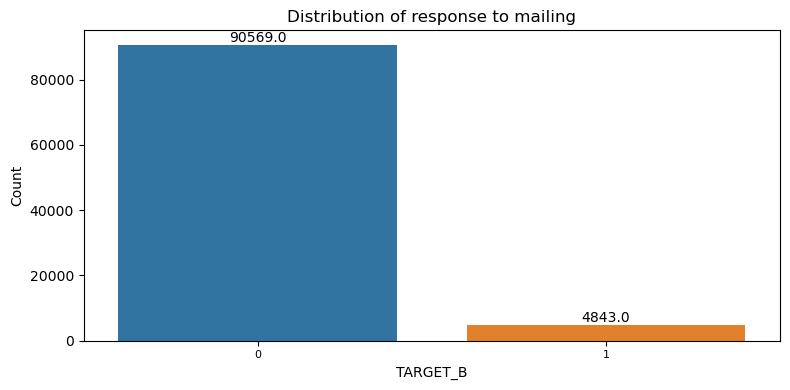

In [848]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x="TARGET_B",data=train_df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Distribution of response to mailing')
plt.xlabel('TARGET_B')
plt.ylabel('Count')

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=8)
plt.tight_layout() 
plt.show()

**Observation**

- The TARGET_B column is highly imbalanced.
- The count of 0 is almost 18 times higher than count of 1.
- While model building , we need to handle the imbalance data issue.

## Analysis of TARGET_D

TARGET_D refers to the donation amount which is associated with the response to the mailing. This is our Output column for the regression problem. 

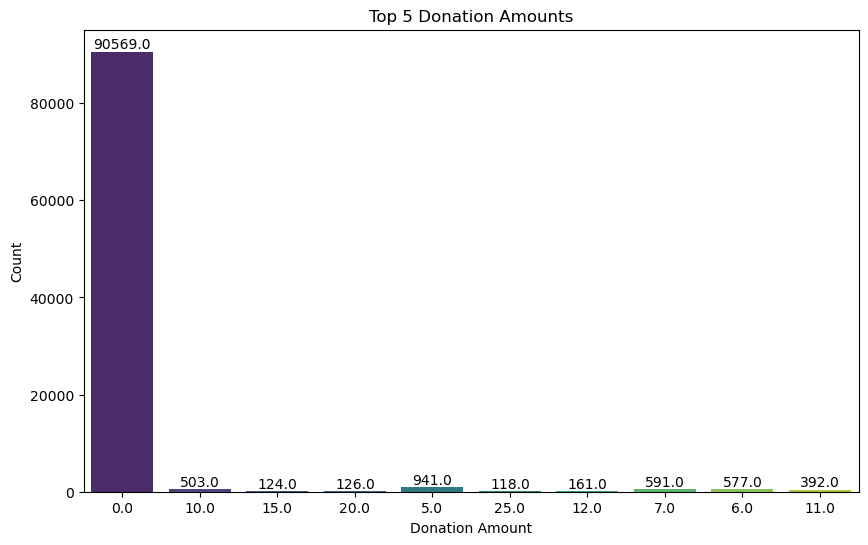

In [849]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'train_df' is your DataFrame and 'donation_amount' is the numerical column representing donation amounts

# Calculate the value counts of donation amounts and select the top 5
donation_counts = train_df['TARGET_D'].value_counts().nlargest(10)
donation_counts = donation_counts.sort_values(ascending=False)
# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=donation_counts.index, y=donation_counts.values, palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
# Customize the x-axis ticks and labels
plt.xticks(range(len(donation_counts)), donation_counts.index)

# Add labels and title
plt.xlabel('Donation Amount')
plt.ylabel('Count')
plt.title('Top 5 Donation Amounts')

# Show plot
plt.show()


In [850]:
train_df["TARGET_D"].value_counts().head(10)

TARGET_D
0.0     90569
10.0      941
15.0      591
20.0      577
5.0       503
25.0      392
12.0      161
7.0       126
6.0       124
11.0      118
Name: count, dtype: int64

**Observation**

- Most of the people have not donated. No response to the mail sent.
- Amount 10, 15 ,20 and 5 were donated most ( in decresing order).
  

# Exploratory Data Analysis

In this section , we will look into the data in depth and will try to find some key insights. 


## Checking for the missing values 

In [851]:
# Checking for the missing data
def missing_data(data):
    pd.set_option('display.max_columns', None)
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [852]:
%%time
missing_data(train_df)

CPU times: total: 562 ms
Wall time: 556 ms


MAILCODE PVASTATE    DOB  NOEXCH RECINHSE   RECP3 RECPGVG RECSWEEP  \
Total          0        0      0       0        0       0       0        0   
Percent      0.0      0.0    0.0     0.0      0.0     0.0     0.0      0.0   
Types     object   object  int32  object   object  object  object   object   

         DOMAIN       AGE AGEFLAG HOMEOWNR CHILD03 CHILD07 CHILD12 CHILD18  \
Total         0     23665       0        0       0       0       0       0   
Percent     0.0  24.80296     0.0      0.0     0.0     0.0     0.0     0.0   
Types    object   float64  object   object  object  object  object  object   

           NUMCHLD     INCOME  GENDER    WEALTH1    HIT    MBCRAFT   MBGARDEN  \
Total        83026      21286       0      44732      0      52854      52854   
Percent  87.018404  22.309563     0.0  46.882992    0.0  55.395548  55.395548   
Types      float64    float64  object    float64  int64    float64    float64   

           MBBOOKS   MBCOLECT    MAGFAML     MAGFEM    MAGMALE   PUBGARDN  \
Total        52854      52914      52854      52854      52854      52854   
Percent  55.395548  55.458433  55.395548  55.395548  55.395548  55.395548   
Types      float64    float64    float64    float64    float64    float64   

          PUBCULIN    PUBHLTH   PUBDOITY   PUBNEWFN   PUBPHOTO     PUBOPP  \
Total        52854      52854      52854      52854      52854      52854   
Percent  55.395548  55.395548  55.395548  55.395548  55.395548  55.395548   
Types      float64    float64    float64    float64    float64    float64   

        DATASRCE MALEMILI MALEVET VIETVETS WWIIVETS LOCALGOV STATEGOV FEDGOV  \
Total          0        0       0        0        0        0        0      0   
Percent      0.0      0.0     0.0      0.0      0.0      0.0      0.0    0.0   
Types     object    int64   int64    int64    int64    int64    int64  int64   

          SOLP3   SOLIH   MAJOR    WEALTH2 GEOCODE COLLECT1 VETERANS   BIBLE  \
Total         0       0       0      43823       0        0        0       0   
Percent     0.0     0.0     0.0  45.930281     0.0      0.0      0.0     0.0   
Types    object  object  object    float64  object   object   object  object   

          CATLG   HOMEE    PETS  CDPLAY  STEREO PCOWNERS   PHOTO  CRAFTS  \
Total         0       0       0       0       0        0       0       0   
Percent     0.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
Types    object  object  object  object  object   object  object  object   

         FISHER GARDENIN   BOATS  WALKER KIDSTUFF   CARDS  PLATES LIFESRC  \
Total         0        0       0       0        0       0       0       0   
Percent     0.0      0.0     0.0     0.0      0.0     0.0     0.0     0.0   
Types    object   object  object  object   object  object  object  object   

        PEPSTRFL POP901 POP902 POP903 POP90C1 POP90C2 POP90C3 POP90C4 POP90C5  \
Total          0      0      0      0       0       0       0       0       0   
Percent      0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0     0.0   
Types     object  int64  int64  int64   int64   int64   int64   int64   int64   

          ETH1   ETH2   ETH3   ETH4   ETH5   ETH6   ETH7   ETH8   ETH9  ETH10  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Types    int64  int64  int64  int64  int64  int64  int64  int64  int64  int64   

         ETH11  ETH12  ETH13  ETH14  ETH15  ETH16 AGE901 AGE902 AGE903 AGE904  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Types    int64  int64  int64  int64  int64  int64  int64  int64  int64  int64   

        AGE905 AGE906 AGE907  CHIL1  CHIL2  CHIL3  AGEC1  AGEC2  AGEC3  AGEC4  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0    

In [853]:
%%time
missing_data(test_df)

CPU times: total: 562 ms
Wall time: 561 ms


MAILCODE PVASTATE    DOB  NOEXCH RECINHSE   RECP3 RECPGVG RECSWEEP  \
Total          0        0      0       0        0       0       0        0   
Percent      0.0      0.0    0.0     0.0      0.0     0.0     0.0      0.0   
Types     object   object  int64  object   object  object  object   object   

         DOMAIN        AGE AGEFLAG HOMEOWNR CHILD03 CHILD07 CHILD12 CHILD18  \
Total         0      24016       0        0       0       0       0       0   
Percent     0.0  24.921394     0.0      0.0     0.0     0.0     0.0     0.0   
Types    object    float64  object   object  object  object  object  object   

           NUMCHLD     INCOME  GENDER    WEALTH1    HIT    MBCRAFT   MBGARDEN  \
Total        84035      21515       0      45211      0      53356      53356   
Percent  87.203088  22.326107     0.0  46.915438    0.0  55.367501  55.367501   
Types      float64    float64  object    float64  int64    float64    float64   

           MBBOOKS   MBCOLECT    MAGFAML     MAGFEM    MAGMALE   PUBGARDN  \
Total        53356      53409      53356      53356      53356      53356   
Percent  55.367501  55.422499  55.367501  55.367501  55.367501  55.367501   
Types      float64    float64    float64    float64    float64    float64   

          PUBCULIN    PUBHLTH   PUBDOITY   PUBNEWFN   PUBPHOTO     PUBOPP  \
Total        53356      53356      53356      53356      53356      53356   
Percent  55.367501  55.367501  55.367501  55.367501  55.367501  55.367501   
Types      float64    float64    float64    float64    float64    float64   

        DATASRCE MALEMILI MALEVET VIETVETS WWIIVETS LOCALGOV STATEGOV FEDGOV  \
Total          0        0       0        0        0        0        0      0   
Percent      0.0      0.0     0.0      0.0      0.0      0.0      0.0    0.0   
Types     object    int64   int64    int64    int64    int64    int64  int64   

          SOLP3   SOLIH   MAJOR    WEALTH2 GEOCODE COLLECT1 VETERANS   BIBLE  \
Total         0       0       0      44234       0        0        0       0   
Percent     0.0     0.0     0.0  45.901605     0.0      0.0      0.0     0.0   
Types    object  object  object    float64  object   object   object  object   

          CATLG   HOMEE    PETS  CDPLAY  STEREO PCOWNERS   PHOTO  CRAFTS  \
Total         0       0       0       0       0        0       0       0   
Percent     0.0     0.0     0.0     0.0     0.0      0.0     0.0     0.0   
Types    object  object  object  object  object   object  object  object   

         FISHER GARDENIN   BOATS  WALKER KIDSTUFF   CARDS  PLATES LIFESRC  \
Total         0        0       0       0        0       0       0       0   
Percent     0.0      0.0     0.0     0.0      0.0     0.0     0.0     0.0   
Types    object   object  object  object   object  object  object  object   

        PEPSTRFL POP901 POP902 POP903 POP90C1 POP90C2 POP90C3 POP90C4 POP90C5  \
Total          0      0      0      0       0       0       0       0       0   
Percent      0.0    0.0    0.0    0.0     0.0     0.0     0.0     0.0     0.0   
Types     object  int64  int64  int64   int64   int64   int64   int64   int64   

          ETH1   ETH2   ETH3   ETH4   ETH5   ETH6   ETH7   ETH8   ETH9  ETH10  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Types    int64  int64  int64  int64  int64  int64  int64  int64  int64  int64   

         ETH11  ETH12  ETH13  ETH14  ETH15  ETH16 AGE901 AGE902 AGE903 AGE904  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Types    int64  int64  int64  int64  int64  int64  int64  int64  int64  int64   

        AGE905 AGE906 AGE907  CHIL1  CHIL2  CHIL3  AGEC1  AGEC2  AGEC3  AGEC4  \
Total        0      0      0      0      0      0      0      0      0      0   
Percent    0.0    0.0    0.0    0.0    0.0

**Observations**

There are missing values in the folliwing columns :- 
- Age, NUMCHLD, INCOME, WEALTH1, MBCRAFT, MBGARDEN, MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,
  WEALTH2,MSA,ADI,DMA, ADATE_3 to ADATE_24 , NEXTDATE and TIMELAG
- RDATE columns have more than 90 percent of the missing data
- RAMNT columns have more than 85% of the missing data

In [854]:
# Dropping columns with higher percentage  of missing values and of less buisness significance 

train_df = train_df.drop(columns =['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12',
                                   'RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21',
                                   'RDATE_22','RDATE_23','RDATE_24','RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9',
                                   'RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18',
                                   'RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','RAMNTALL','NUMCHLD','ADATE_4',
                                   'ADATE_7','ADATE_8','ADATE_9','ADATE_10','ADATE_11','ADATE_12','ADATE_13','ADATE_16','ADATE_17','ADATE_18',
                                   'ADATE_19','ADATE_21','ADATE_22','ADATE_23'
                                  ])

In [855]:

test_df = test_df.drop(columns =['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12',
                                   'RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21',
                                   'RDATE_22','RDATE_23','RDATE_24','RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9',
                                   'RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18',
                                   'RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','RAMNTALL','NUMCHLD','ADATE_4',
                                   'ADATE_7','ADATE_8','ADATE_9','ADATE_10','ADATE_11','ADATE_12','ADATE_13','ADATE_16','ADATE_17','ADATE_18',
                                   'ADATE_19','ADATE_21','ADATE_22','ADATE_23'
                                  ])

In [856]:
train_df.shape

(95412, 390)

In [857]:
test_df.shape

(96367, 388)

## Descriptive statistics

In [858]:
train_df.describe()

DOB           AGE        INCOME       WEALTH1           HIT  \
count  95412.000000  71747.000000  74126.000000  50680.000000  95412.000000   
mean    2723.602933     61.611649      3.886248      5.345699      3.321438   
std     2132.241295     16.664199      1.854960      2.742490      9.306899   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%      201.000000     48.000000      2.000000      3.000000      0.000000   
50%     2610.000000     62.000000      4.000000      6.000000      0.000000   
75%     4601.000000     75.000000      5.000000      8.000000      3.000000   
max     9710.000000     98.000000      7.000000      9.000000    241.000000   

            MBCRAFT      MBGARDEN       MBBOOKS      MBCOLECT       MAGFAML  \
count  42558.000000  42558.000000  42558.000000  42498.000000  42558.000000   
mean       0.152075      0.059166      1.116382      0.063932      0.448329   
std        0.470023      0.262078      1.669967      0.297344      0.821010   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      2.000000      0.000000      1.000000   
max        6.000000      4.000000      9.000000      6.000000      9.000000   

             MAGFEM       MAGMALE      PUBGARDN      PUBCULIN       PUBHLTH  \
count  42558.000000  42558.000000  42558.000000  42558.000000  42558.000000   
mean       0.126322      0.065722      0.141806      0.145237      0.714484   
std        0.380916      0.276398      0.490414      0.427822      1.249891   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        5.000000      4.000000      5.000000      6.000000      9.000000   

           PUBDOITY      PUBNEWFN      PUBPHOTO        PUBOPP      MALEMILI  \
count  42558.000000  42558.000000  42558.000000  42558.000000  95412.000000   
mean       0.237723      0.376239      0.005874      0.237558      1.048443   
std        0.728572      0.959573      0.077942      0.878639      5.065522   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      9.000000      2.000000      9.000000     99.000000   

            MALEVET      VIETVETS      WWIIVETS      LOCALGOV      STATEGOV  \
count  95412.000000  95412.000000  95412.000000  95412.000000  95412.000000   
mean      30.445332     29.702312     32.637719      6.842326      4.568566   
std       11.470554     15.097752     17.709065      4.391699      5.126618   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       24.000000     20.000000     21.000000      4.000000      1.000000   
50%       31.000000     29.000000     32.000000      6.000000      3.000000   
75%       37.000000     39.000000     43.000000      9.000000      6.000000   
max       99.000000     99.000000     99.000000     99.000000     99.000000   

             FEDGOV       WEALTH2        POP901        POP902        POP903  \
count  95412.000000  51589.000000  95412.000000  95412.000000  95412.000000   
mean       3.110867      4.954525   3255.880204    864.993083   1222.573460   
std        4.155168      2.802759   5743.217266   1458.103434   2123.096242   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      3.000000    990.000000    265.000000

In [859]:
def describe_with_skewness(df):
    # Use describe method to get statistics
    description = df.describe()
    
    # Calculate skewness for each numerical column
    skewness = df.skew()
    
    # Create a DataFrame to store results
    results = pd.DataFrame(index=description.columns)
    results['count'] = description.loc['count']
    results['mean'] = description.loc['mean']
    results['std'] = description.loc['std']
    results['min'] = description.loc['min']
    results['25%'] = description.loc['25%']
    results['50%'] = description.loc['50%']
    results['75%'] = description.loc['75%']
    results['max'] = description.loc['max']
    results['skewness'] = skewness
    
    # Classify distribution based on skewness
    results['distribution'] = np.where(
        results['skewness'].abs() < 0.5, 'approximately normal',
        np.where(results['skewness'] > 0, 'right-skewed', 'left-skewed')
    )
    
    # Filter columns based on distribution
    right_skewed_columns = results[results['distribution'] == 'right-skewed'].index
    normal_columns = results[results['distribution'] == 'approximately normal'].index
    left_skewed_columns = results[results['distribution'] == 'left-skewed'].index
    
    return right_skewed_columns, normal_columns, left_skewed_columns

right_skewed_columns, normal_columns, left_skewed_columns = describe_with_skewness(train_df.select_dtypes(include=np.number))
print("Right-skewed columns:", right_skewed_columns)
print("Normal columns:", normal_columns)
print("Left-skewed columns:", left_skewed_columns)

Right-skewed columns: Index(['HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML',
       'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN',
       ...
       'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'LASTDATE', 'TIMELAG',
       'AVGGIFT', 'TARGET_B', 'TARGET_D', 'RFA_2F'],
      dtype='object', length=230)
Normal columns: Index(['DOB', 'AGE', 'INCOME', 'WEALTH1', 'MALEVET', 'VIETVETS', 'WWIIVETS',
       'WEALTH2', 'POP90C1', 'AGE902', 'AGE904', 'AGEC2', 'AGEC3', 'AGEC4',
       'AGEC5', 'CHILC4', 'HHN2', 'HHN3', 'HHN4', 'HHP1', 'HHD1', 'HHD4',
       'ETHC1', 'HVP4', 'HUR2', 'RP2', 'RP3', 'MSA', 'DMA', 'IC7', 'IC8',
       'IC9', 'IC17', 'IC18', 'IC19', 'HHAS3', 'MC1', 'TPE11', 'LFC7', 'EC4',
       'EC5', 'SEC2', 'SEC4', 'AFC4', 'AFC5', 'VC1', 'POBC2', 'HC6', 'HC11',
       'MHUC2', 'ADATE_5', 'ADATE_15', 'CARDPROM', 'NUMPROM', 'CARDPM12',
       'NEXTDATE', 'HPHONE_D', 'CLUSTER2'],
      dtype='object')
Left-skewed columns: Index(['POP90C4', 'POP90C5', 'ETH1', 'AGE903',

## Data Quality isssues 

In [860]:
def display_unique_values(df):
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Create an empty list to store unique values data
    unique_values_data = []
    
    # Iterate over each categorical column
    for col in categorical_columns:
        unique_values = df[col].unique()
        unique_values_data.append({'Column': col, 'Unique_Values': unique_values})
    
    # Create a DataFrame from the list of unique values data
    unique_values_df = pd.DataFrame(unique_values_data)
    
    return unique_values_df

unique_values_df = display_unique_values(train_df)
unique_values_df

Column                                      Unique_Values
0   MAILCODE                                             [ , B]
1   PVASTATE                                          [ , P, E]
2     NOEXCH                                       [0, 1, X,  ]
3   RECINHSE                                             [ , X]
4      RECP3                                             [ , X]
5    RECPGVG                                             [ , X]
6   RECSWEEP                                             [ , X]
7     DOMAIN  [T2, S1, R2, S2, T1, R3, U1, C2, C1, U3,  , R1...
8    AGEFLAG                                          [ , E, I]
9   HOMEOWNR                                          [ , H, U]
10   CHILD03                                       [ , M, F, B]
11   CHILD07                                       [ , M, B, F]
12   CHILD12                                       [ , F, M, B]
13   CHILD18                                       [ , M, F, B]
14    GENDER                              [F, M,  , C, U, J, A]
15  DATASRCE                                       [ , 3, 1, 2]
16     SOLP3                                [ , 00, 12, 01, 02]
17     SOLIH                    [ , 12, 00, 02, 01, 04, 06, 03]
18     MAJOR                                             [ , X]
19   GEOCODE                    [ , 02, 03, 05, 04, 14, 01, 12]
20  COLLECT1                                             [ , Y]
21  VETERANS                                             [ , Y]
22     BIBLE                                             [ , Y]
23     CATLG                                             [ , Y]
24     HOMEE                                             [ , Y]
25      PETS                                             [ , Y]
26    CDPLAY                                             [ , Y]
27    STEREO                                             [ , Y]
28  PCOWNERS                                             [ , Y]
29     PHOTO                                             [ , Y]
30    CRAFTS                                             [ , Y]
31    FISHER                                             [ , Y]
32  GARDENIN                                             [ , Y]
33     BOATS                                             [ , Y]
34    WALKER                                             [ , Y]
35  KIDSTUFF                                             [ , Y]
36     CARDS                                             [ , Y]
37    PLATES                                             [ , Y]
38   LIFESRC                                       [ , 3, 1, 2]
39  PEPSTRFL                                             [X,  ]
40     RFA_2  [L4E, L2G, L2F, L1F, L1E, L3E, L4D, L1G, L3D, ...
41    RFA_2R                                                [L]
42    RFA_2A                                       [E, G, F, D]
43  MDMAUD_R                                    [X, C, D, L, I]
44  MDMAUD_F                                       [X, 1, 2, 5]
45  MDMAUD_A                                    [X, C, M, L, T]
46  GEOCODE2                               [C, A, D, B,  , nan]

**Observations**

- There are lot of columns where blank values are present and they refer to a category like in MAILCODE, NOEXCH etc.
- There are blank values nut they need to be replaced with value N ( which refers to N ) 
- Gender takes 4 values. Male, Female, Unknown and A.The A value is a mistake as it takes one (1) value. It will be replaced acoordingly.
  

In [861]:
train_df['TARGET_B'] = train_df['TARGET_B'].astype('str')

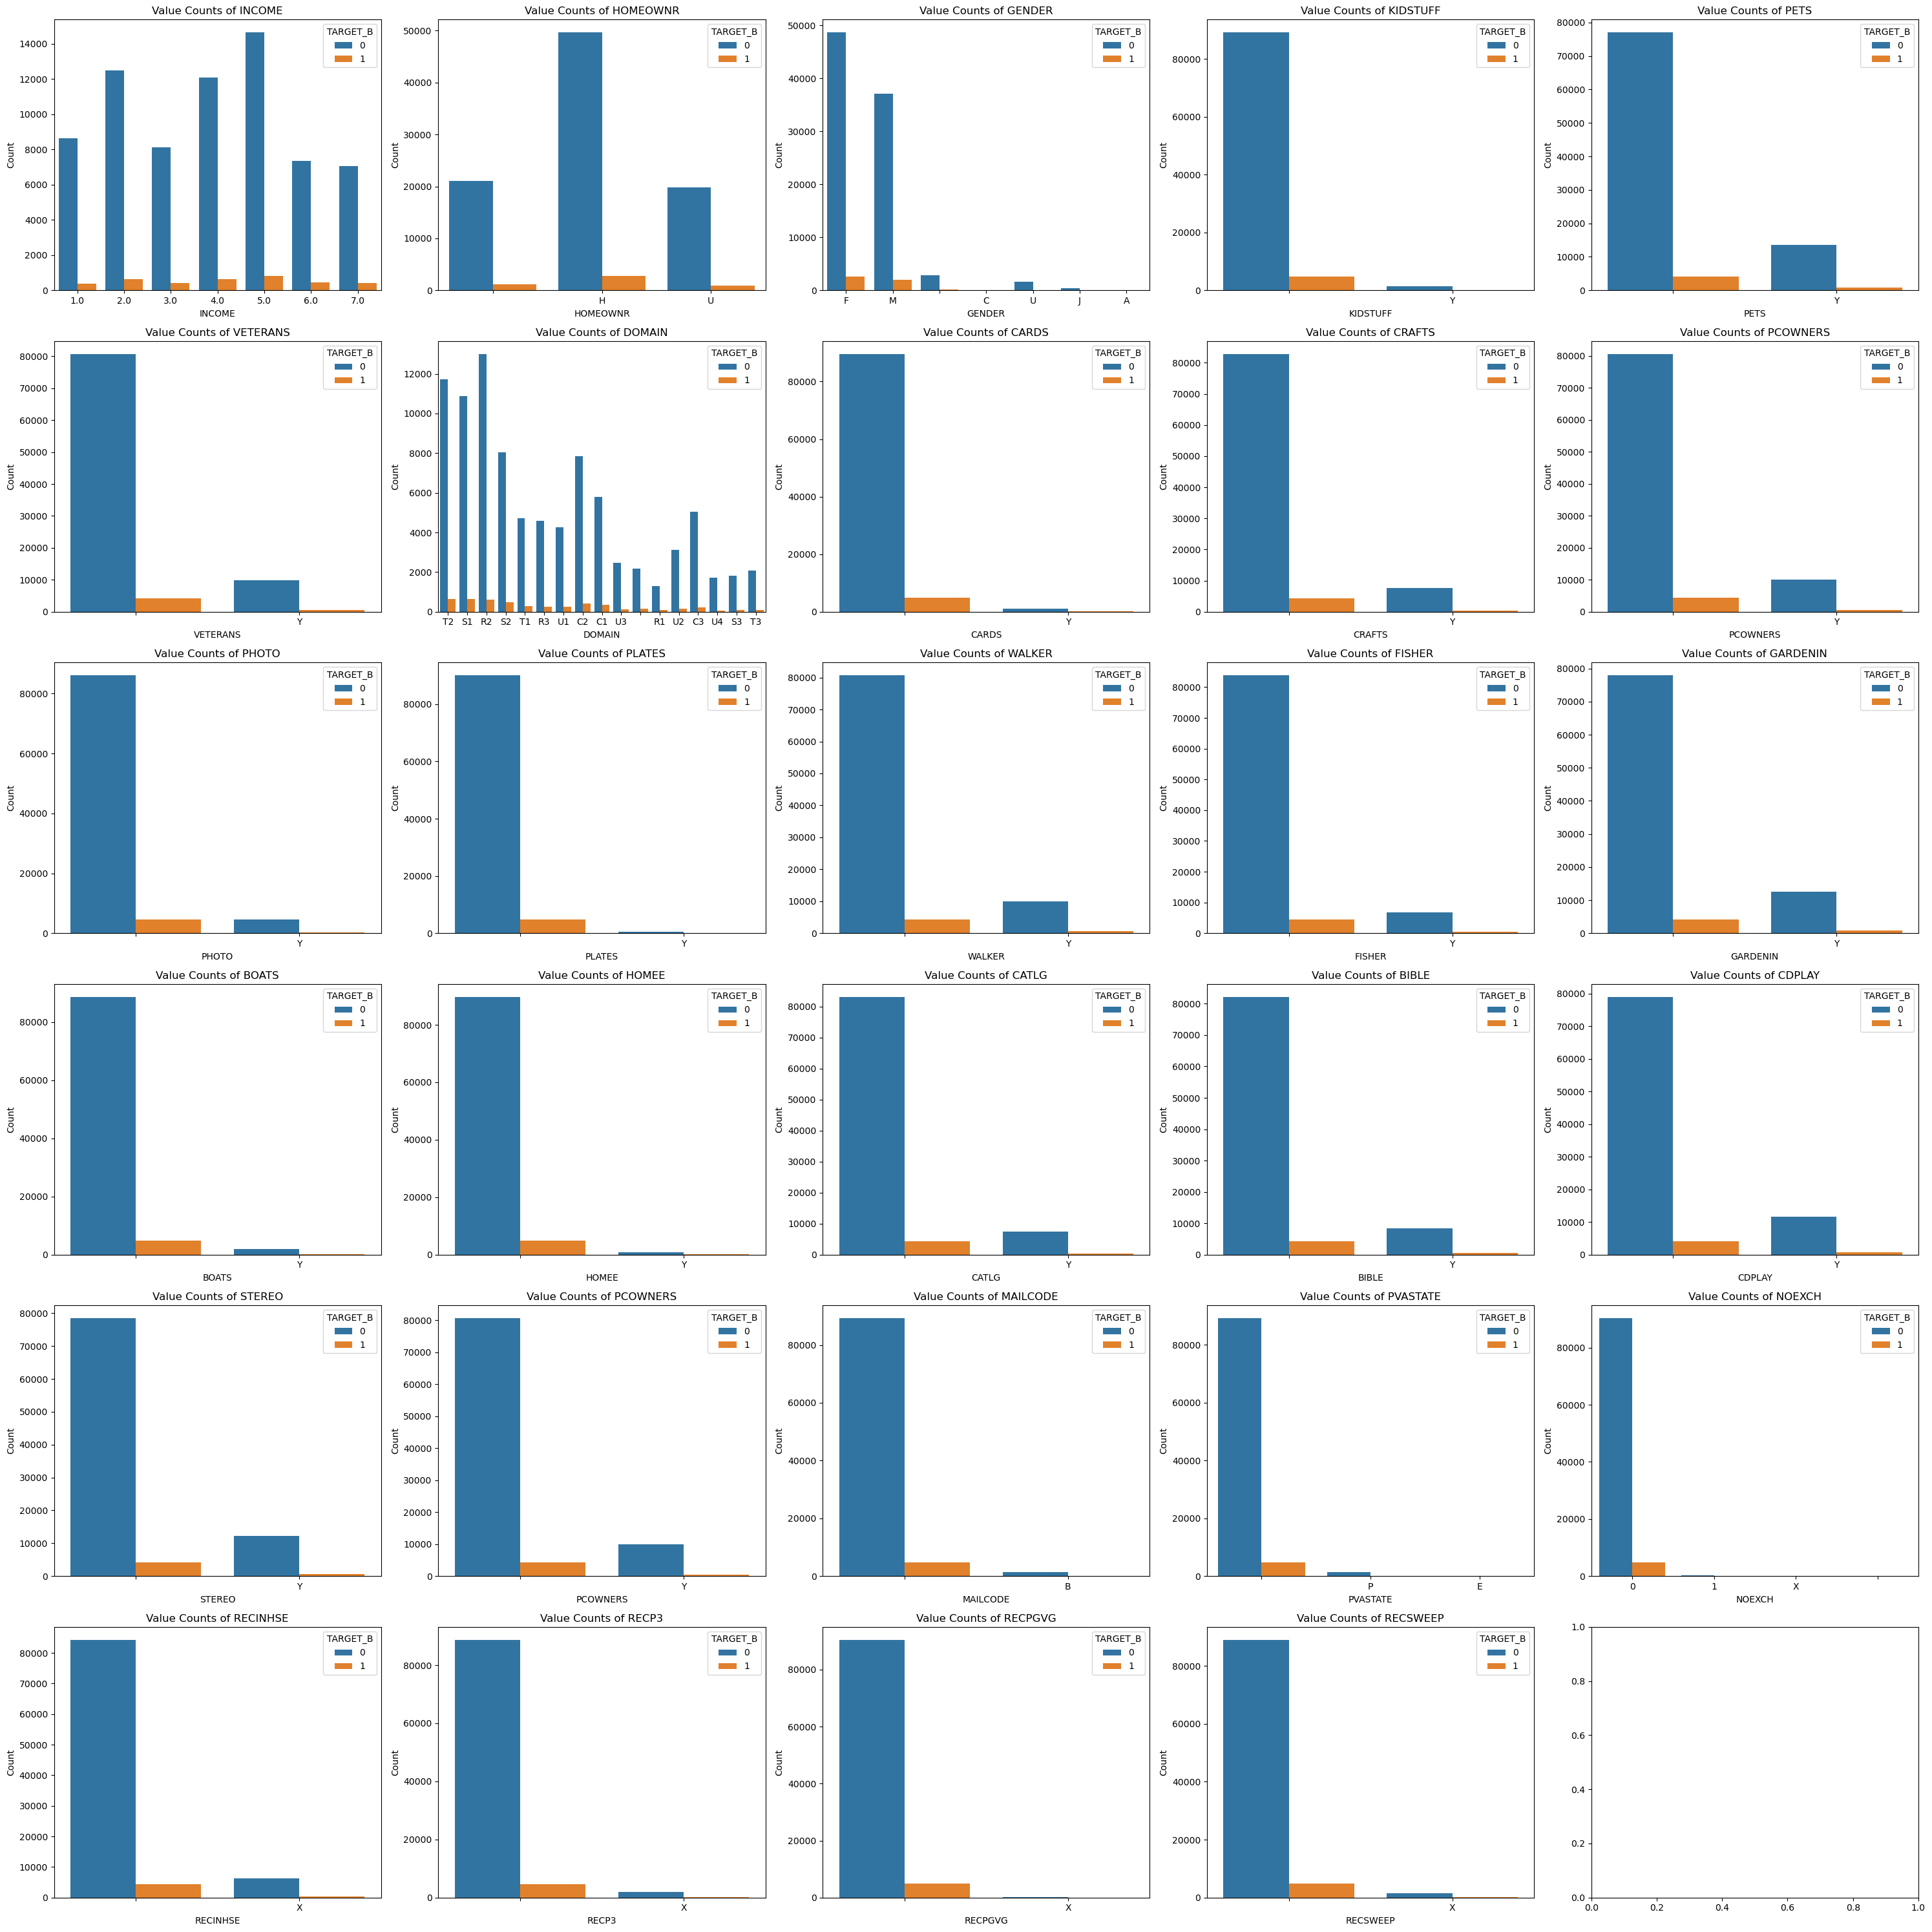

In [862]:
def get_count_plots(df, cols_list, rows, cols,hue_col):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
    for i, col in enumerate(cols_list):
        ax = axes[i // cols, i % cols]  # Calculate the row and column index
        sns.countplot(data=df, x=col,hue=hue_col, ax=ax)
        ax.set_title(f'Value Counts of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

cols_list = ['INCOME','HOMEOWNR','GENDER','KIDSTUFF', 'PETS', 'VETERANS', 'DOMAIN','CARDS','CRAFTS','PCOWNERS','PHOTO','PLATES',
             'WALKER','FISHER','GARDENIN','BOATS','HOMEE','CATLG','BIBLE','CDPLAY','STEREO','PCOWNERS','MAILCODE','PVASTATE','NOEXCH','RECINHSE',
             'RECP3','RECPGVG','RECSWEEP'] 
get_count_plots(train_df, cols_list, 6, 5,"TARGET_B")

In [863]:
train_df['TARGET_B'] = train_df['TARGET_B'].astype('int')

## Analyse the numerical columns wrt donation amount

<Axes: xlabel='POP901', ylabel='TARGET_D'>

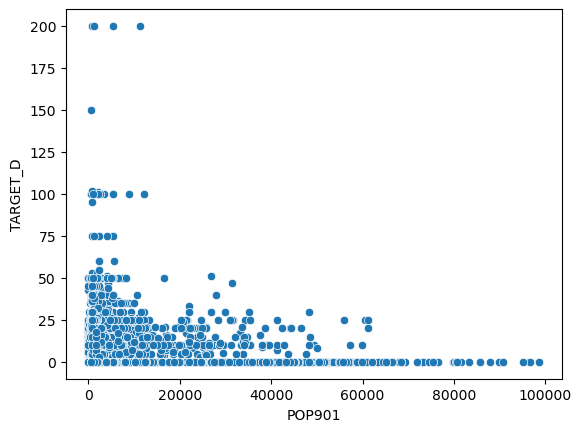

In [864]:
sns.scatterplot(x="POP901",y="TARGET_D",data = train_df)

<Axes: xlabel='ETH1', ylabel='TARGET_D'>

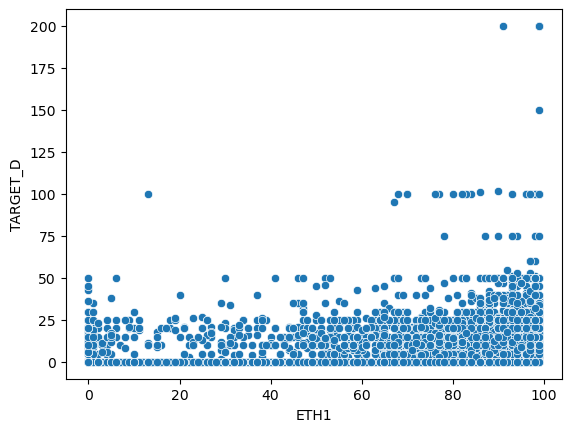

In [865]:
sns.scatterplot(x="ETH1",y="TARGET_D",data =train_df)    

<Axes: xlabel='AGE', ylabel='TARGET_D'>

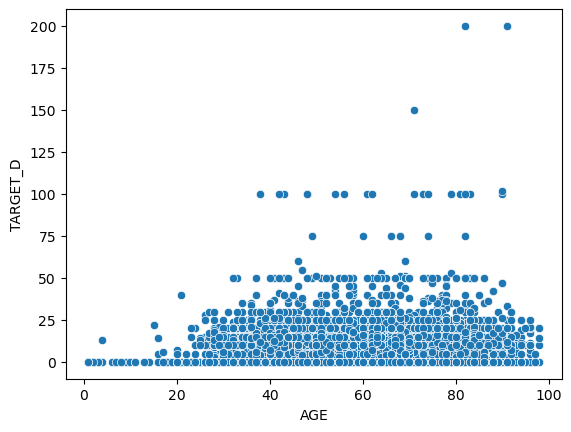

In [866]:
sns.scatterplot(x="AGE",y="TARGET_D",data =train_df) 

<Axes: xlabel='MARR2', ylabel='TARGET_D'>

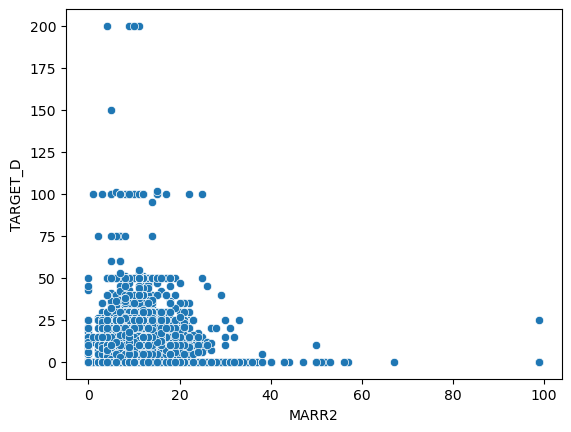

In [867]:
sns.scatterplot(x="MARR2",y="TARGET_D",data =train_df)   

C:\Users\Saurav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


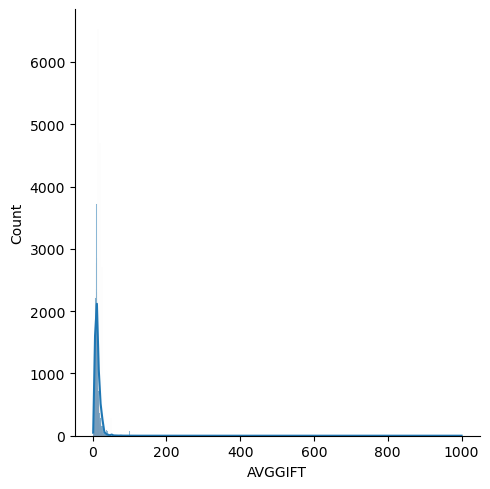

In [868]:
# Average amount of gifts till date 

sns.displot(train_df["AVGGIFT"],kde= True)

# Splitting Data into categorical and Numerical columns 

In [869]:
# Selecting categorical columns (including 'TARGET_B' and 'TARGET_D')
categorical_columns =  train_df.select_dtypes(include=['object']).columns.tolist() + ['TARGET_B']
# Selecting numerical columns
numerical_columns = train_df.select_dtypes(include=['number']).columns.tolist()
# Creating DataFrame with only categorical columns
categorical_data = train_df[categorical_columns]
# Creating DataFrame with only numerical columns
numerical_data = train_df[numerical_columns]

# Checking the columns with constant values 

## Remove  the constant numerical columns 

In [870]:
varModel=VarianceThreshold(threshold=0)
varModel.fit(numerical_data)

VarianceThreshold(threshold=0)

In [871]:
constArr=varModel.get_support()
collections.Counter(constArr)

Counter({True: 341, False: 2})

In [872]:
#Print out constant feature name
constCol=[col for col in numerical_data.columns if col not in numerical_data.columns[constArr]]
constCol

['ADATE_5', 'ADATE_15']

In [873]:
#Create variance threshold model
quasiModel=VarianceThreshold(threshold=0.01) #It will search for the features having 99% of same value in all samples.
quasiModel.fit(numerical_data)

VarianceThreshold(threshold=0.01)

In [874]:
quasiArr=quasiModel.get_support()
collections.Counter(quasiArr)

Counter({True: 334, False: 9})

In [875]:
#Print out quasi constant feature name
quasiCols=[col for col in numerical_data.columns if col not in numerical_data.columns[quasiArr]]
quasiCols

['PUBPHOTO',
 'ADATE_2',
 'ADATE_3',
 'ADATE_5',
 'ADATE_6',
 'ADATE_14',
 'ADATE_15',
 'ADATE_20',
 'ADATE_24']

## Remove the constant categorical columns

In [876]:
categorical_data.columns

Index(['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG',
       'RECSWEEP', 'DOMAIN', 'AGEFLAG', 'HOMEOWNR', 'CHILD03', 'CHILD07',
       'CHILD12', 'CHILD18', 'GENDER', 'DATASRCE', 'SOLP3', 'SOLIH', 'MAJOR',
       'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS',
       'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN',
       'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC', 'PEPSTRFL',
       'RFA_2', 'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A',
       'GEOCODE2', 'TARGET_B'],
      dtype='object')

In [877]:
ord_enc = OrdinalEncoder()
# Fit and transform the data using the encoder
data_encoded = ord_enc.fit_transform(categorical_data)
# Convert the encoded data back to a DataFrame
categorical_data_encoded = pd.DataFrame(data_encoded, columns=categorical_data.columns)

In [878]:
categorical_data_encoded.head()

MAILCODE  PVASTATE  NOEXCH  RECINHSE  RECP3  RECPGVG  RECSWEEP  DOMAIN  \
0       0.0       0.0     1.0       0.0    0.0      0.0       0.0    11.0   
1       0.0       0.0     1.0       0.0    0.0      0.0       0.0     7.0   
2       0.0       0.0     1.0       0.0    0.0      0.0       0.0     5.0   
3       0.0       0.0     1.0       0.0    0.0      0.0       0.0     5.0   
4       0.0       0.0     1.0       1.0    1.0      0.0       0.0     8.0   

   AGEFLAG  HOMEOWNR  CHILD03  CHILD07  CHILD12  CHILD18  GENDER  DATASRCE  \
0      0.0       0.0      0.0      0.0      0.0      0.0     3.0       0.0   
1      1.0       1.0      0.0      0.0      0.0      3.0     5.0       3.0   
2      0.0       2.0      0.0      0.0      0.0      0.0     5.0       3.0   
3      1.0       2.0      0.0      0.0      0.0      0.0     3.0       3.0   
4      1.0       1.0      0.0      0.0      0.0      0.0     3.0       3.0   

   SOLP3  SOLIH  MAJOR  GEOCODE  COLLECT1  VETERANS  BIBLE  CATLG  HOMEE  \
0    0.0    0.0    0.0      0.0       0.0       0.0    0.0    0.0    0.0   
1    0.0    0.0    0.0      2.0       0.0       0.0    0.0    0.0    0.0   
2    0.0    0.0    0.0      0.0       0.0       0.0    0.0    0.0    0.0   
3    0.0    0.0    0.0      0.0       0.0       0.0    0.0    0.0    0.0   
4    0.0    7.0    0.0      0.0       0.0       0.0    1.0    1.0    0.0   

   PETS  CDPLAY  STEREO  PCOWNERS  PHOTO  CRAFTS  FISHER  GARDENIN  BOATS  \
0   0.0     0.0     0.0       0.0    0.0     0.0     0.0       0.0    0.0   
1   0.0     0.0     0.0       0.0    0.0     0.0     0.0       0.0    0.0   
2   0.0     0.0     0.0       0.0    0.0     0.0     0.0       0.0    0.0   
3   0.0     0.0     0.0       0.0    0.0     0.0     0.0       0.0    0.0   
4   0.0     0.0     1.0       0.0    0.0     1.0     0.0       1.0    0.0   

   WALKER  KIDSTUFF  CARDS  PLATES  LIFESRC  PEPSTRFL  RFA_2  RFA_2R  RFA_2A  \
0     0.0       0.0    0.0     0.0      0.0       1.0   11.0     0.0     1.0   
1     0.0       0.0    0.0     0.0      0.0       0.0    5.0     0.0     3.0   
2     0.0       0.0    0.0     0.0      0.0       1.0   11.0     0.0     1.0   
3     0.0       0.0    0.0     0.0      0.0       1.0   11.0     0.0     1.0   
4     1.0       0.0    1.0     0.0      3.0       0.0    4.0     0.0     2.0   

   MDMAUD_R  MDMAUD_F  MDMAUD_A  GEOCODE2  TARGET_B  
0       4.0       3.0       4.0       3.0       0.0  
1       4.0       3.0       4.0       1.0       0.0  
2       4.0       3.0       4.0       3.0       0.0  
3       4.0       3.0       4.0       3.0       0.0  
4       4.0       3.0       4.0       1.0       0.0

In [879]:
varModel=VarianceThreshold(threshold=0)
varModel.fit(categorical_data_encoded)

VarianceThreshold(threshold=0)

In [880]:
constArr=varModel.get_support()
collections.Counter(constArr)

Counter({True: 47, False: 1})

In [881]:
#Print out constant feature name
constCol=[col for col in categorical_data_encoded.columns if col not in categorical_data_encoded.columns[constArr]]
constCol

['RFA_2R']

In [882]:
#Create variance threshold model
quasiModel=VarianceThreshold(threshold=0.01) #It will search for the features having 99% of same value in all samples.
quasiModel.fit(categorical_data_encoded)

VarianceThreshold(threshold=0.01)

In [883]:
quasiArr=quasiModel.get_support()
collections.Counter(quasiArr)

Counter({True: 42, False: 6})

In [884]:
#Print out quasi constant feature name
quasiCols=[col for col in categorical_data_encoded.columns if col not in categorical_data_encoded.columns[quasiArr]]
quasiCols

['NOEXCH', 'RECPGVG', 'MAJOR', 'HOMEE', 'PLATES', 'RFA_2R']

**Observation**

These columns need to removed as the following features have the high constant values in our data

- **Numerical Data** :- 'ADATE_5' , 'PUBPHOTO' ,'ADATE_2' ,'ADATE_3' ,'ADATE_6' ,'ADATE_14' ,'ADATE_15' ,'ADATE_20' ,'ADATE_24'
- **Categorical Data** :- 'RFA_2R' , 'NOEXCH' , 'RECPGVG' , 'MAJOR' , 'HOMEE' , 'PLATES'

In [885]:
train_df = train_df.drop(columns =["ADATE_5","PUBPHOTO","ADATE_2","ADATE_3","ADATE_6","ADATE_14","ADATE_15","ADATE_20","ADATE_24","RFA_2R","NOEXCH",
                                  "RECPGVG","MAJOR","HOMEE","PLATES"])

In [886]:
test_df = test_df.drop(columns =["ADATE_5","PUBPHOTO","ADATE_2","ADATE_3","ADATE_6","ADATE_14","ADATE_15","ADATE_20","ADATE_24","RFA_2R","NOEXCH",
                                  "RECPGVG","MAJOR","HOMEE","PLATES"])

In [887]:
train_df.shape

(95412, 375)

In [888]:
test_df.shape

(96367, 373)

# Chi Sqaure Test on the catgeorical columns wrt Target

In [889]:
categorical_data_encoded.columns

Index(['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG',
       'RECSWEEP', 'DOMAIN', 'AGEFLAG', 'HOMEOWNR', 'CHILD03', 'CHILD07',
       'CHILD12', 'CHILD18', 'GENDER', 'DATASRCE', 'SOLP3', 'SOLIH', 'MAJOR',
       'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS',
       'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN',
       'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC', 'PEPSTRFL',
       'RFA_2', 'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A',
       'GEOCODE2', 'TARGET_B'],
      dtype='object')

In [890]:
# Dropping the null values from the categorical_data_encoded
categorical_data_encoded = categorical_data_encoded.dropna(subset=['GEOCODE2'])

In [891]:
X = categorical_data_encoded.drop(columns=["TARGET_B"])
y = categorical_data_encoded["TARGET_B"]
k = 10
selector = SelectKBest(chi2, k=k)
selector.fit(X, y)

SelectKBest(score_func=<function chi2 at 0x00000227EC0EEF20>)

In [892]:
selected_indices = selector.get_support(indices=True)
# Get the names of the selected features
selected_features = X.columns[selected_indices]
print(selected_features)

Index(['RECINHSE', 'RECP3', 'SOLIH', 'GEOCODE', 'GARDENIN', 'WALKER',
       'LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_2A'],
      dtype='object')


# Checking for the duplicate columns 

In [893]:
def duplicateColumns(data):
    dupliCols=[]
    for i in range(0,len(data.columns)):
        col1=data.columns[i]
        for col2 in data.columns[i+1:]:
            if data[col1].equals(data[col2]):
                dupliCols.append(col1+','+col2)
    return dupliCols

In [894]:
duplCols=duplicateColumns(train_df)
duplCols

[]

#  Kendall rank correlation between the numerical columns and the target 

Kendall rank statistical test is choosen because of the following reasons :- 

- relationship between the variables where target is categorical and input features is numerical
- robust to outliers
- not assume any specific distribution of the data.

In [895]:
numerical_columns = train_df.select_dtypes(include=['number']).columns.tolist()
numerical_data = train_df[numerical_columns]

In [896]:
nan_counts = numerical_data.isna().sum()
nan_columns = nan_counts[nan_counts > 0]
print("Columns with NaN values and their counts:")
print(nan_columns)
print(len(nan_columns))

Columns with NaN values and their counts:
AGE         23665
INCOME      21286
WEALTH1     44732
MBCRAFT     52854
MBGARDEN    52854
MBBOOKS     52854
MBCOLECT    52914
MAGFAML     52854
MAGFEM      52854
MAGMALE     52854
PUBGARDN    52854
PUBCULIN    52854
PUBHLTH     52854
PUBDOITY    52854
PUBNEWFN    52854
PUBOPP      52854
WEALTH2     43823
MSA           132
ADI           132
DMA           132
NEXTDATE     9973
TIMELAG      9973
CLUSTER2      132
dtype: int64
23


In [897]:
# Impute missing values with mean
numerical_data = numerical_data.fillna(numerical_data.mean())

In [898]:

X = numerical_data.drop(columns=["TARGET_B"])  # Features
y = numerical_data["TARGET_B"]  # Target variable
# Calculate Kendall's tau coefficient for each numerical feature
kendall_correlation = {}
for column in X.columns:
    tau, _ = kendalltau(X[column], y)
    kendall_correlation[column] = abs(tau)

# Sort features based on absolute Kendall's tau coefficient values
sorted_features = sorted(kendall_correlation, key=kendall_correlation.get, reverse=True)

# Select the top K features
k = 31  # Number of top features to select
selected_features = sorted_features[:k]

print("Selected Features:")
print(selected_features)

# Display correlation of each feature with the target variable
for feature in sorted_features:
    print(f"{feature}: Kendall's tau = {kendall_correlation[feature]}")

Selected Features:
['TARGET_D', 'RFA_2F', 'LASTGIFT', 'MAXRAMNT', 'CARDGIFT', 'AVGGIFT', 'NGIFTALL', 'MINRAMNT', 'LASTDATE', 'FISTDATE', 'NUMPROM', 'CARDPROM', 'MAXRDATE', 'HV2', 'HV1', 'HVP3', 'HVP4', 'NEXTDATE', 'HVP5', 'HC21', 'HVP2', 'IC13', 'HVP6', 'HVP1', 'IC5', 'DMA', 'ETHC6', 'RP1', 'HV3', 'HV4', 'IC4']
TARGET_D: Kendall's tau = 0.9880632304023673
RFA_2F: Kendall's tau = 0.06533589270476833
LASTGIFT: Kendall's tau = 0.05574813476946217
MAXRAMNT: Kendall's tau = 0.04945026799216188
CARDGIFT: Kendall's tau = 0.04922190027951196
AVGGIFT: Kendall's tau = 0.048933646616092355
NGIFTALL: Kendall's tau = 0.04594149245197083
MINRAMNT: Kendall's tau = 0.04304492962628796
LASTDATE: Kendall's tau = 0.03494626260648492
FISTDATE: Kendall's tau = 0.028566529931056125
NUMPROM: Kendall's tau = 0.026410440760348822
CARDPROM: Kendall's tau = 0.02620625256218286
MAXRDATE: Kendall's tau = 0.02183033700980132
HV2: Kendall's tau = 0.021163988314948142
HV1: Kendall's tau = 0.021108071752897813
HVP3: K

In [899]:
# Cleaned data 
final_cols = ['RFA_2F', 'LASTGIFT', 'MAXRAMNT', 'CARDGIFT', 'AVGGIFT', 'NGIFTALL', 'MINRAMNT', 'LASTDATE', 'FISTDATE', 'NUMPROM', 'CARDPROM', 
              'MAXRDATE', 'HV2', 'HV1', 'HVP3', 'HVP4', 'NEXTDATE', 'HVP5', 'HC21', 'HVP2', 'IC13', 'HVP6', 'HVP1', 'IC5', 'DMA', 'ETHC6', 'RP1', 
              'HV3', 'HV4', 'IC4','RECINHSE', 'RECP3', 'SOLIH', 'GEOCODE', 'GARDENIN', 'WALKER','LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_2A','TARGET_B','TARGET_D']
train_df = train_df[final_cols]

In [900]:
train_df.shape

(95412, 42)

In [901]:
train_df.columns

Index(['RFA_2F', 'LASTGIFT', 'MAXRAMNT', 'CARDGIFT', 'AVGGIFT', 'NGIFTALL',
       'MINRAMNT', 'LASTDATE', 'FISTDATE', 'NUMPROM', 'CARDPROM', 'MAXRDATE',
       'HV2', 'HV1', 'HVP3', 'HVP4', 'NEXTDATE', 'HVP5', 'HC21', 'HVP2',
       'IC13', 'HVP6', 'HVP1', 'IC5', 'DMA', 'ETHC6', 'RP1', 'HV3', 'HV4',
       'IC4', 'RECINHSE', 'RECP3', 'SOLIH', 'GEOCODE', 'GARDENIN', 'WALKER',
       'LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_2A', 'TARGET_B', 'TARGET_D'],
      dtype='object')

In [902]:
# Cleaned data for test data
final_cols = ['RFA_2F', 'LASTGIFT', 'MAXRAMNT', 'CARDGIFT', 'AVGGIFT', 'NGIFTALL', 'MINRAMNT', 'LASTDATE', 'FISTDATE', 'NUMPROM', 'CARDPROM', 
              'MAXRDATE', 'HV2', 'HV1', 'HVP3', 'HVP4', 'NEXTDATE', 'HVP5', 'HC21', 'HVP2', 'IC13', 'HVP6', 'HVP1', 'IC5', 'DMA', 'ETHC6', 'RP1', 
              'HV3', 'HV4', 'IC4','RECINHSE', 'RECP3', 'SOLIH', 'GEOCODE', 'GARDENIN', 'WALKER','LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_2A']
test_df = test_df[final_cols]

In [903]:
test_df.shape

(96367, 40)

# Classification Model Building 

In [904]:
# Remove the TARGET_D column from the dataset

train_cls_df = train_df.drop(columns=["TARGET_D"])

In [905]:
train_cls_df["TARGET_B"].value_counts()

TARGET_B
0    90569
1     4843
Name: count, dtype: int64

In our dataset , the data is  highly imbalanced where 

- Class 0 :- 95 % of the data.
- Class 1 :- 5 % of the data. 

# Understanding how XGBoost, LightGBM, and CatBoost, handle imbalanced data

Our choice of algorithm here are XGBoost, LightGBM and CatBoost . We will check the following :- 

- how these algorithms handle imbalance data
- Generally , the boosting algorithms do well on the imbalance data
- They produce good results on the imbalanced daata by giving an opportunity to focus more on the minority class and accordingly tune the training algorithm.


## scale_pos_weight hyperparameter 

All the three algorithm uses the scale_pos_weight parameter for handling the imbalance class. These are the characteritics of this hyperparameter 

- scale_pos_weight is 1 by default.- 
Both major class and minority class get the same weight- scale_pos_weight = total_majority_examples / total_minority_examples.

  For example , in our dataset we have used 

- no of negative values :- 90569
- no of positive values :- 4843 

scale_pos_weight = 90669/4843 = 18.7 ( 19 ) 

By adjusting the weight, minority class gets 19 times more impact and 19 times more correction than errors made on the majority class.lass.)

## Encoding the categorical columns 

In [906]:
numerical_cols = train_cls_df.select_dtypes(include=['int', 'float']).columns
categorical_cols = train_cls_df.select_dtypes(include=['object']).columns
# Convert categorical columns to numerical using one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_categorical_cols = encoder.fit_transform(train_cls_df[categorical_cols]).toarray()

## Dividing the data into input and Output

In [907]:
X = pd.concat([train_cls_df[numerical_cols], pd.DataFrame(encoded_categorical_cols)], axis=1)
X= X.drop(columns=["TARGET_B"])
y = train_cls_df["TARGET_B"]
X.columns = X.columns.astype(str)

## Dividing the data into train/test split 

In [908]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Defining the cross validation

In [800]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Xgboost with default scale_pos_weight

In [489]:
xgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 200, 300]}
xgb_grid = GridSearchCV(xgb.XGBClassifier(), param_grid=xgb_params, cv=cv, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_preds = xgb_best.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18105
           1       1.00      0.00      0.00       978

    accuracy                           0.95     19083
   macro avg       0.97      0.50      0.49     19083
weighted avg       0.95      0.95      0.92     19083



In [507]:
print(xgb_best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [490]:
from sklearn.metrics import roc_auc_score, roc_curve
# Calculate AUC-ROC score
xgb_probs = xgb_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, xgb_probs)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.6175808126758869


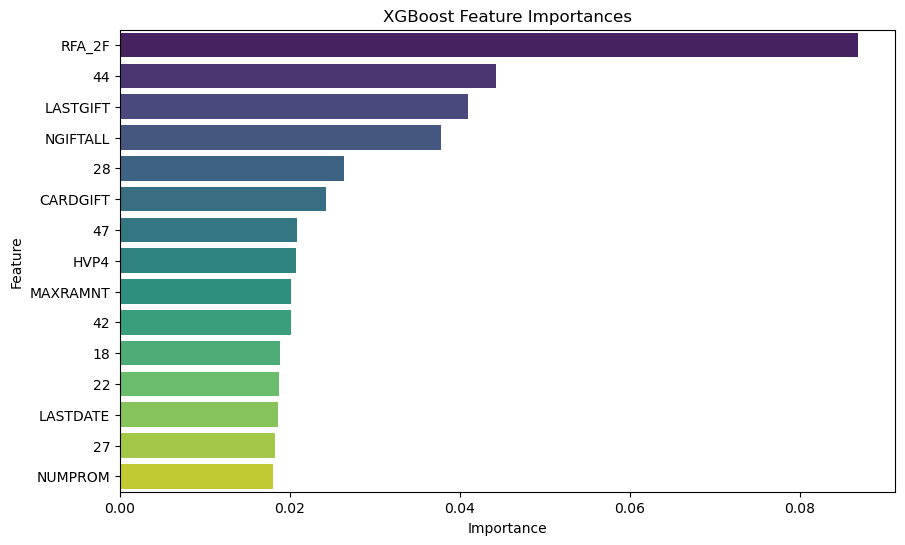

In [494]:
feature_importances  =  xgb_best.feature_importances_
feature_names = X_train.columns

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_15_features = feature_importance_df.head(15)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=top_15_features, x='Importance', y='Feature', palette='viridis')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##  Xgboost with Optuna Hyperparameters ( scale_pos_weight': 12)

In [909]:

best_params = {'verbosity': 1, 'lambda': 0.0012897831631655374, 'alpha': 0.07295070130798546, 'max_depth': 3, 'eta': 0.010996354208650498, 
               'gamma': 0.003084118284934084, 'grow_policy': 'depthwise', 'learning_rate': 0.034910666476050664, 'scale_pos_weight': 12, 
               'colsample_bytree': 0.9091392953393618, 'reg_alpha': 4.336889231714178e-08, 'reg_lambda': 0.008006462256977515, 
               'min_child_weight': 4.61829889157942}

# Initialize XGBoost classifier with the best parameters
xgb_best_with_scale_pos_weight = xgb.XGBClassifier(**best_params)

# Fit the classifier on the training data
xgb_best_with_scale_pos_weight.fit(X_train, y_train)

# Make predictions
xgb_preds_with_scale_pos_weight = xgb_best_with_scale_pos_weight.predict(X_test)

# Print classification report
print("XGBoost Classification Report with scale_pos_weight:")
print(classification_report(y_test, xgb_preds_with_scale_pos_weight))

# Calculate AUC-ROC score
xgb_probs_with_scale_pos_weight = xgb_best_with_scale_pos_weight.predict_proba(X_test)[:, 1]
auc_roc_with_scale_pos_weight = roc_auc_score(y_test, xgb_probs_with_scale_pos_weight)
print("AUC-ROC Score with scale_pos_weight:", auc_roc_with_scale_pos_weight)


XGBoost Classification Report with scale_pos_weight:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     18105
           1       0.11      0.19      0.14       978

    accuracy                           0.88     19083
   macro avg       0.53      0.56      0.54     19083
weighted avg       0.91      0.88      0.90     19083

AUC-ROC Score with scale_pos_weight: 0.6235504490110799


## Xgboost with Optuna tuned Hyperparameters with 10 CV

In [543]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
best_params = {'verbosity': 1, 'lambda': 0.0012897831631655374, 'alpha': 0.07295070130798546, 'max_depth': 3, 'eta': 0.010996354208650498, 
               'gamma': 0.003084118284934084, 'grow_policy': 'depthwise', 'learning_rate': 0.034910666476050664, 'scale_pos_weight': 12, 
               'colsample_bytree': 0.9091392953393618, 'reg_alpha': 4.336889231714178e-08, 'reg_lambda': 0.008006462256977515, 
               'min_child_weight': 4.61829889157942}

# Perform cross-validation
cv_scores = cross_val_score(xgb_best_with_scale_pos_weight, X_train, y_train, cv=10, scoring='roc_auc')

# Fit the classifier on the training data
xgb_best_with_scale_pos_weight.fit(X_train, y_train)

# Make predictions
xgb_preds_with_scale_pos_weight = xgb_best_with_scale_pos_weight.predict(X_test)

# Compute permutation importances
perm_importance = permutation_importance(xgb_best_with_scale_pos_weight, X_test, y_test, n_repeats=10, random_state=42)

# Print mean cross-validation score
print("Mean Cross-Validation ROC-AUC Score:", cv_scores.mean())

# Print classification report
print("XGBoost Classification Report with scale_pos_weight:")
print(classification_report(y_test, xgb_preds_with_scale_pos_weight))

# Calculate AUC-ROC score
xgb_probs_with_scale_pos_weight = xgb_best_with_scale_pos_weight.predict_proba(X_test)[:, 1]
auc_roc_with_scale_pos_weight = roc_auc_score(y_test, xgb_probs_with_scale_pos_weight)
print("AUC-ROC Score with scale_pos_weight:", auc_roc_with_scale_pos_weight)

# Print feature importances
print("Feature Importance:")
for i, imp in enumerate(perm_importance.importances_mean.argsort()[::-1]):
    print(f"{X_test.columns[imp]}: {perm_importance.importances_mean[imp]} (±{perm_importance.importances_std[imp]})")

Mean Cross-Validation ROC-AUC Score: 0.6230785821262688
XGBoost Classification Report with scale_pos_weight:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     18105
           1       0.11      0.19      0.14       978

    accuracy                           0.88     19083
   macro avg       0.53      0.56      0.54     19083
weighted avg       0.91      0.88      0.90     19083

AUC-ROC Score with scale_pos_weight: 0.6235504490110799
Feature Importance:
28: 0.0440444374574228 (±0.0013870876751944088)
FISTDATE: 0.011161767017764468 (±0.0010340732966724064)
NUMPROM: 0.01100979929780429 (±0.0005967694669423585)
NGIFTALL: 0.009993187653932766 (±0.0006323375185793216)
CARDPROM: 0.00536603259445575 (±0.0006608555371979131)
46: 0.0014829953361630399 (±0.0001947377684437632)
HC21: 0.000660273541895895 (±0.0003002997176941755)
IC5: 0.00022009118063194278 (±0.00039270542357479495)
RP1: 0.00016768851857670297 (±0.00013005998685732128)
22: 0.00

## Hyperparameter tuning using Optuna (run only once)

The below code is commented as it needs to be run once to get the tuned list of parameters

In [520]:
# import optuna
# from sklearn.model_selection import train_test_split
# import xgboost as xgb
# from sklearn.metrics import roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # Define the objective function for Optuna
# def objective(trial):
#     # Split the data into training and validation sets
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
    
#     # Define the hyperparameter search space
#     params = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'verbosity': trial.suggest_categorical('verbosity', [0, 1, 2, 3]),
#         'booster': 'gbtree',
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 3, 9),
#         'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 20),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'min_child_weight': trial.suggest_uniform('min_child_weight', 0.1, 10.0),
#         'enable_categorical':True
#     }
    
#     # Train the XGBoost model
#     model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100, evals=[(xgb.DMatrix(X_valid, label=y_valid), 'eval')], early_stopping_rounds=10, 
#                       verbose_eval=False)
    
#     # Calculate ROC AUC score on the validation set
#     preds = model.predict(xgb.DMatrix(X_valid))
#     roc_auc = roc_auc_score(y_valid, preds)
    
#     return roc_auc

# # Run Optuna to find the best hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

# # Plot the ROC AUC curve for the best model
# best_model = xgb.train(best_params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
# preds = best_model.predict(xgb.DMatrix(X_valid))
# fpr, tpr, thresholds = roc_curve(y_valid, preds)
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC AUC Curve')
# plt.show()


[I 2024-05-13 17:34:39,679] A new study created in memory with name: no-name-05ac0c5b-22ef-4bc6-9201-2677c97fa1f8
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/ta

[17:35:02] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:02] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:02] ======== Monitor (0): HostSketchContainer ========
[17:35:02] AllReduce: 0.006498s, 1 calls @ 6498us

[17:35:02] MakeCuts: 0.006613s, 1 calls @ 6613us

[17:35:02] PushRowPage: 0.062837s, 1 calls @ 62837us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:35:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:35:03,109] Trial 10 finished with value: 0.6103074901628175 and parameters: {'verbosity': 3, 'lambda': 1.0023847999065285e-08, 'alpha': 0.6269030432663157, 'max_depth': 3, 'eta': 0.027625228996013388, 'gamma': 0.8474862516105509, 'grow_policy': 'lossguide', 'learning_rate': 0.01073998192440947, 'scale_pos_weight': 16, 'colsample_bytree': 0.6843430299968192, 'reg_alpha': 0.7190687766922287, 'reg_lambda': 0.6932210995764635, 'min_child_weight': 6.734433325254702}. Best is trial 5 with value: 0.6278178234380936.


[17:35:02] ======== Monitor (0): Learner ========
[17:35:02] Configure: 0s, 1 calls @ 0us

[17:35:02] EvalOneIter: 0.167239s, 31 calls @ 167239us

[17:35:02] GetGradient: 0.007283s, 31 calls @ 7283us

[17:35:02] PredictRaw: 0.000147s, 31 calls @ 147us

[17:35:02] UpdateOneIter: 0.367972s, 31 calls @ 367972us

[17:35:02] ======== Monitor (0): GBTree ========
[17:35:02] BoostNewTrees: 0.359028s, 31 calls @ 359028us

[17:35:02] CommitModel: 4.2e-05s, 31 calls @ 42us

[17:35:02] ======== Monitor (0): HistUpdater ========
[17:35:02] BuildHistogram: 0.052014s, 93 calls @ 52014us

[17:35:02] EvaluateSplits: 0.019502s, 124 calls @ 19502us

[17:35:02] InitData: 0.196432s, 31 calls @ 196432us

[17:35:02] InitRoot: 0.068695s, 31 calls @ 68695us

[17:35:02] LeafPartition: 1e-05s, 31 calls @ 10us

[17:35:02] UpdatePosition: 0.022125s, 217 calls @ 22125us

[17:35:02] UpdatePredictionCache: 0.002239s, 31 calls @ 2239us

[17:35:02] UpdateTree: 0.356271s, 31 calls @ 356271us

[17:35:03] DEBUG: C:\build

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:35:05] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:05] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:05] ======== Monitor (0): HostSketchContainer ========
[17:35:05] AllReduce: 0.005293s, 1 calls @ 5293us

[17:35:05] MakeCuts: 0.00539s, 1 calls @ 5390us

[17:35:05] PushRowPage: 0.058727s, 1 calls @ 58727us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:35:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:35:06,155] Trial 12 finished with value: 0.6221107003006465 and parameters: {'verbosity': 3, 'lambda': 0.0008189214464149249, 'alpha': 0.1518187517620497, 'max_depth': 5, 'eta': 0.02577585137587187, 'gamma': 0.01468592057295397, 'grow_policy': 'lossguide', 'learning_rate': 0.11203750746482022, 'scale_pos_weight': 12, 'colsample_bytree': 0.8045797411283113, 'reg_alpha': 5.946804359298688e-07, 'reg_lambda': 0.07942095635748082, 'min_child_weight': 2.11710628990202}. Best is trial 5 with value: 0.6278178234380936.


[17:35:06] ======== Monitor (0): Learner ========
[17:35:06] Configure: 0s, 1 calls @ 0us

[17:35:06] EvalOneIter: 0.209857s, 31 calls @ 209857us

[17:35:06] GetGradient: 0.008673s, 31 calls @ 8673us

[17:35:06] PredictRaw: 0.000155s, 31 calls @ 155us

[17:35:06] UpdateOneIter: 0.558401s, 31 calls @ 558401us

[17:35:06] ======== Monitor (0): GBTree ========
[17:35:06] BoostNewTrees: 0.547725s, 31 calls @ 547725us

[17:35:06] CommitModel: 4.1e-05s, 31 calls @ 41us

[17:35:06] ======== Monitor (0): HistUpdater ========
[17:35:06] BuildHistogram: 0.119338s, 454 calls @ 119338us

[17:35:06] EvaluateSplits: 0.080009s, 485 calls @ 80009us

[17:35:06] InitData: 0.221646s, 31 calls @ 221646us

[17:35:06] InitRoot: 0.080584s, 31 calls @ 80584us

[17:35:06] LeafPartition: 1e-05s, 31 calls @ 10us

[17:35:06] UpdatePosition: 0.04297s, 881 calls @ 42970us

[17:35:06] UpdatePredictionCache: 0.002727s, 31 calls @ 2727us

[17:35:06] UpdateTree: 0.544474s, 31 calls @ 544474us

[17:35:06] DEBUG: C:\buil

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:35:06] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:06] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:06] ======== Monitor (0): HostSketchContainer ========
[17:35:06] AllReduce: 0.013722s, 1 calls @ 13722us

[17:35:06] MakeCuts: 0.013959s, 1 calls @ 13959us

[17:35:06] PushRowPage: 0.140551s, 1 calls @ 140551us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:35:08,069] Trial 13 finished with value: 0.6255737267391788 and parameters: {'verbosity': 3, 'lambda': 0.00019370156566057728, 'alpha': 0.7650129772660451, 'max_depth': 4, 'eta': 0.02476578287481695, 'gamma': 0.015602753419790758, 'grow_policy': 'lossguide', 'learning_rate': 0.14750268046241075, 'scale_pos_weight': 12, 'colsample_bytree': 0.81055861407812, 'reg_alpha': 8.329927768181264e-07, 'reg_lambda': 0.48071211073048886, 'min_child_weight': 6.667472643613028}. Best is trial 5 with value: 0.6278178234380936.


[17:35:07] ======== Monitor (0): Learner ========
[17:35:07] Configure: 0.002083s, 1 calls @ 2083us

[17:35:07] EvalOneIter: 0.345237s, 33 calls @ 345237us

[17:35:07] GetGradient: 0.012646s, 33 calls @ 12646us

[17:35:07] PredictRaw: 0.00028s, 33 calls @ 280us

[17:35:07] UpdateOneIter: 0.764847s, 33 calls @ 764847us

[17:35:07] ======== Monitor (0): GBTree ========
[17:35:07] BoostNewTrees: 0.748547s, 33 calls @ 748547us

[17:35:07] CommitModel: 6.4e-05s, 33 calls @ 64us

[17:35:07] ======== Monitor (0): HistUpdater ========
[17:35:07] BuildHistogram: 0.102242s, 229 calls @ 102242us

[17:35:07] EvaluateSplits: 0.076561s, 262 calls @ 76561us

[17:35:07] InitData: 0.39733s, 33 calls @ 397330us

[17:35:07] InitRoot: 0.123554s, 33 calls @ 123554us

[17:35:07] LeafPartition: 2e-05s, 33 calls @ 20us

[17:35:07] UpdatePosition: 0.0475s, 467 calls @ 47500us

[17:35:07] UpdatePredictionCache: 0.003848s, 33 calls @ 3848us

[17:35:07] UpdateTree: 0.743898s, 33 calls @ 743898us

[17:35:08] DEBUG

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:35:08] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:08] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:08] ======== Monitor (0): HostSketchContainer ========
[17:35:08] AllReduce: 0.005803s, 1 calls @ 5803us

[17:35:08] MakeCuts: 0.005949s, 1 calls @ 5949us

[17:35:08] PushRowPage: 0.068776s, 1 calls @ 68776us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:35:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:35:09,103] Trial 14 finished with value: 0.6178203257445591 and parameters: {'verbosity': 3, 'lambda': 0.00013267809870436167, 'alpha': 0.03193152549991751, 'max_depth': 4, 'eta': 0.02733283707916955, 'gamma': 0.004701301170611757, 'grow_policy': 'lossguide', 'learning_rate': 0.17373460185254624, 'scale_pos_weight': 14, 'colsample_bytree': 0.778335972796538, 'reg_alpha': 3.4190112701048138e-06, 'reg_lambda': 0.3868333574236959, 'min_child_weight': 6.556109127569428}. Best is trial 5 with value: 0.6278178234380936.


[17:35:08] ======== Monitor (0): Learner ========
[17:35:08] Configure: 0.001145s, 1 calls @ 1145us

[17:35:08] EvalOneIter: 0.13806s, 20 calls @ 138060us

[17:35:08] GetGradient: 0.008798s, 20 calls @ 8798us

[17:35:08] PredictRaw: 0.000108s, 20 calls @ 108us

[17:35:08] UpdateOneIter: 0.380395s, 20 calls @ 380395us

[17:35:08] ======== Monitor (0): GBTree ========
[17:35:08] BoostNewTrees: 0.369752s, 20 calls @ 369752us

[17:35:08] CommitModel: 2.9e-05s, 20 calls @ 29us

[17:35:08] ======== Monitor (0): HistUpdater ========
[17:35:08] BuildHistogram: 0.05503s, 140 calls @ 55030us

[17:35:08] EvaluateSplits: 0.026502s, 160 calls @ 26502us

[17:35:08] InitData: 0.201546s, 20 calls @ 201546us

[17:35:08] InitRoot: 0.065291s, 20 calls @ 65291us

[17:35:08] LeafPartition: 8e-06s, 20 calls @ 8us

[17:35:08] UpdatePosition: 0.020241s, 291 calls @ 20241us

[17:35:08] UpdatePredictionCache: 0.001644s, 20 calls @ 1644us

[17:35:08] UpdateTree: 0.367745s, 20 calls @ 367745us

[17:35:09] DEBUG: 

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:35:09] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:09] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:09] ======== Monitor (0): HostSketchContainer ========
[17:35:09] AllReduce: 0.011405s, 1 calls @ 11405us

[17:35:09] MakeCuts: 0.011575s, 1 calls @ 11575us

[17:35:09] PushRowPage: 0.111723s, 1 calls @ 111723us



[I 2024-05-13 17:35:11,433] Trial 15 finished with value: 0.6160530033624356 and parameters: {'verbosity': 3, 'lambda': 0.9967884484691584, 'alpha': 0.6400319370601645, 'max_depth': 4, 'eta': 0.01786608910835456, 'gamma': 0.001969234768351647, 'grow_policy': 'lossguide', 'learning_rate': 0.06819434166772875, 'scale_pos_weight': 10, 'colsample_bytree': 0.7031851451053656, 'reg_alpha': 6.152122846918806e-08, 'reg_lambda': 0.016436497353602874, 'min_child_weight': 6.9765313991088815}. Best is trial 5 with value: 0.6278178234380936.


[17:35:11] ======== Monitor (0): Learner ========
[17:35:11] Configure: 0.001839s, 1 calls @ 1839us

[17:35:11] EvalOneIter: 0.545049s, 53 calls @ 545049us

[17:35:11] GetGradient: 0.030906s, 53 calls @ 30906us

[17:35:11] PredictRaw: 0.000291s, 53 calls @ 291us

[17:35:11] UpdateOneIter: 1.01973s, 53 calls @ 1019730us

[17:35:11] ======== Monitor (0): GBTree ========
[17:35:11] BoostNewTrees: 0.984772s, 53 calls @ 984772us

[17:35:11] CommitModel: 7.8e-05s, 53 calls @ 78us

[17:35:11] ======== Monitor (0): HistUpdater ========
[17:35:11] BuildHistogram: 0.211005s, 368 calls @ 211005us

[17:35:11] EvaluateSplits: 0.088512s, 421 calls @ 88512us

[17:35:11] InitData: 0.362837s, 53 calls @ 362837us

[17:35:11] InitRoot: 0.235885s, 53 calls @ 235885us

[17:35:11] LeafPartition: 2.7e-05s, 53 calls @ 27us

[17:35:11] UpdatePosition: 0.081203s, 781 calls @ 81203us

[17:35:11] UpdatePredictionCache: 0.006386s, 53 calls @ 6386us

[17:35:11] UpdateTree: 0.977272s, 53 calls @ 977272us

[17:35:11]

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:35:13] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:35:13] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:35:13] ======== Monitor (0): HostSketchContainer ========
[17:35:13] AllReduce: 0.01377s, 1 calls @ 13770us

[17:35:13] MakeCuts: 0.013991s, 1 calls @ 13991us

[17:35:13] PushRowPage: 0.129762s, 1 calls @ 129762us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:35:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:35:14,136] Trial 17 finished with value: 0.6118454247092845 and parameters: {'verbosity': 3, 'lambda': 2.753541496066878e-08, 'alpha': 0.0010359784115301694, 'max_depth': 5, 'eta': 0.018832734949660476, 'gamma': 0.0019624553350717014, 'grow_policy': 'depthwise', 'learning_rate': 0.16131236350773814, 'scale_pos_weight': 15, 'colsample_bytree': 0.6085225799447174, 'reg_alpha': 0.0030369762281670684, 'reg_lambda': 0.10514219693633647, 'min_child_weight': 3.8030194093616645}. Best is trial 5 with value: 0.6278178234380936.


[17:35:14] ======== Monitor (0): Learner ========
[17:35:14] Configure: 0s, 1 calls @ 0us

[17:35:14] EvalOneIter: 0.217684s, 24 calls @ 217684us

[17:35:14] GetGradient: 0.009s, 24 calls @ 9000us

[17:35:14] PredictRaw: 0.000174s, 24 calls @ 174us

[17:35:14] UpdateOneIter: 0.598094s, 24 calls @ 598094us

[17:35:14] ======== Monitor (0): GBTree ========
[17:35:14] BoostNewTrees: 0.585728s, 24 calls @ 585728us

[17:35:14] CommitModel: 4.6e-05s, 24 calls @ 46us

[17:35:14] ======== Monitor (0): HistUpdater ========
[17:35:14] BuildHistogram: 0.081312s, 96 calls @ 81312us

[17:35:14] EvaluateSplits: 0.031573s, 120 calls @ 31573us

[17:35:14] InitData: 0.364212s, 24 calls @ 364212us

[17:35:14] InitRoot: 0.071499s, 24 calls @ 71499us

[17:35:14] LeafPartition: 1.2e-05s, 24 calls @ 12us

[17:35:14] UpdatePosition: 0.033045s, 120 calls @ 33045us

[17:35:14] UpdatePredictionCache: 0.002904s, 24 calls @ 2904us

[17:35:14] UpdateTree: 0.582289s, 24 calls @ 582289us

[17:35:14] DEBUG: C:\buildk

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:41] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:41] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:41] ======== Monitor (0): HostSketchContainer ========
[17:36:41] AllReduce: 0.006961s, 1 calls @ 6961us

[17:36:41] MakeCuts: 0.00709s, 1 calls @ 7090us

[17:36:41] PushRowPage: 0.059203s, 1 calls @ 59203us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:36:44,167] Trial 55 finished with value: 0.6293800716359824 and parameters: {'verbosity': 3, 'lambda': 0.4052934829931811, 'alpha': 0.06524752994855974, 'max_depth': 3, 'eta': 0.010846693700957094, 'gamma': 0.003002551640678075, 'grow_policy': 'depthwise', 'learning_rate': 0.03309851511921724, 'scale_pos_weight': 12, 'colsample_bytree': 0.919399437056777, 'reg_alpha': 0.0004556805376960545, 'reg_lambda': 0.00798468721388515, 'min_child_weight': 4.267227455397751}. Best is trial 54 with value: 0.63824755368191.


[17:36:44] ======== Monitor (0): Learner ========
[17:36:44] Configure: 0s, 1 calls @ 0us

[17:36:44] EvalOneIter: 1.0842s, 100 calls @ 1084199us

[17:36:44] GetGradient: 0.040888s, 100 calls @ 40888us

[17:36:44] PredictRaw: 0.000546s, 100 calls @ 546us

[17:36:44] UpdateOneIter: 1.02383s, 100 calls @ 1023832us

[17:36:44] ======== Monitor (0): GBTree ========
[17:36:44] BoostNewTrees: 0.979726s, 100 calls @ 979726us

[17:36:44] CommitModel: 0.000141s, 100 calls @ 141us

[17:36:44] ======== Monitor (0): HistUpdater ========
[17:36:44] BuildHistogram: 0.206164s, 200 calls @ 206164us

[17:36:44] EvaluateSplits: 0.104062s, 300 calls @ 104062us

[17:36:44] InitData: 0.216555s, 100 calls @ 216555us

[17:36:44] InitRoot: 0.36597s, 100 calls @ 365970us

[17:36:44] LeafPartition: 5.6e-05s, 100 calls @ 56us

[17:36:44] UpdatePosition: 0.093023s, 300 calls @ 93023us

[17:36:44] UpdatePredictionCache: 0.011342s, 100 calls @ 11342us

[17:36:44] UpdateTree: 0.965987s, 100 calls @ 965987us

[17:36:

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:44] ======== Monitor (0): HostSketchContainer ========
[17:36:44] AllReduce: 0.006837s, 1 calls @ 6837us

[17:36:44] MakeCuts: 0.006974s, 1 calls @ 6974us

[17:36:44] PushRowPage: 0.064684s, 1 calls @ 64684us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:36:46] ======== Monitor (0): Learner ========
[17:36:46] Configure: 0.001021s, 1 calls @ 1021us

[17:36:46] EvalOneIter: 1.04441s, 100 calls @ 1044411us

[17:36:46] GetGradient: 0.036279s, 100 calls @ 36279us

[17:36:46] PredictRaw: 0.000522s, 100 calls @ 522us

[17:36:46] UpdateOneIter: 0.953511s, 100 calls @ 953511us

[17:36:46] ======== Monitor (0): GBTree ========
[17:36:46] BoostNewTrees: 0.913946s, 100 calls @ 913946us

[17:36:46] CommitModel: 0.000135s, 100 calls @ 135us

[17:36:46] ======== Monitor (0): HistUpdater ========
[17:36:46] BuildHistogram: 0.182966s, 200 calls @ 182966us

[17:36:46] EvaluateSplits: 0.099028s, 300 calls @ 99028us

[17:36:46] InitData: 0.218119s, 100 calls @ 218119us

[17:36:46] InitRoot: 0.332146s, 100 calls @ 332146us

[17:36:46] LeafPartition: 5.8e-05s, 100 calls @ 58us

[17:36:46] UpdatePosition: 0.088678s, 300 calls @ 88678us

[17:36:46] UpdatePredictionCache: 0.010773s, 100 calls @ 10773us

[17:36:46] UpdateTree: 0.900871s, 100 calls @ 900871

[I 2024-05-13 17:36:46,965] Trial 56 finished with value: 0.6306242576243781 and parameters: {'verbosity': 3, 'lambda': 0.29376337131364255, 'alpha': 0.06099928567316872, 'max_depth': 3, 'eta': 0.010126285352043244, 'gamma': 0.0010517216526473672, 'grow_policy': 'depthwise', 'learning_rate': 0.03300102784797395, 'scale_pos_weight': 12, 'colsample_bytree': 0.8635169974912501, 'reg_alpha': 0.000467040090717088, 'reg_lambda': 0.007445086106606004, 'min_child_weight': 4.6593399033216665}. Best is trial 54 with value: 0.63824755368191.


[17:36:46] ======== Monitor (0): Learner ========
[17:36:46] Configure: 0.00072s, 1 calls @ 720us

[17:36:46] ======== Monitor (0): GBTree ========
[17:36:46] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:47] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:47] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:47] ======== Monitor (0): HostSketchContainer ========
[17:36:47] AllReduce: 0.006558s, 1 calls @ 6558us

[17:36:47] MakeCuts: 0.006685s, 1 calls @ 6685us

[17:36:47] PushRowPage: 0.066806s, 1 calls @ 66806us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:36:49] ======== Monitor (0): Learner ========
[17:36:49] Configure: 0.001061s, 1 calls @ 1061us

[17:36:49] EvalOneIter: 0.953339s, 100 calls @ 953339us

[17:36:49] GetGradient: 0.029642s, 100 calls @ 29642us

[17:36:49] PredictRaw: 0.000493s, 100 calls @ 493us

[17:36:49] UpdateOneIter: 0.875373s, 100 calls @ 875373us

[17:36:49] ======== Monitor (0): GBTree ========
[17:36:49] BoostNewTrees: 0.842465s, 100 calls @ 842465us

[17:36:49] CommitModel: 0.000118s, 100 calls @ 118us

[17:36:49] ======== Monitor (0): HistUpdater ========
[17:36:49] BuildHistogram: 0.157075s, 200 calls @ 157075us

[17:36:49] EvaluateSplits: 0.092648s, 300 calls @ 92648us

[17:36:49] InitData: 0.222645s, 100 calls @ 222645us

[17:36:49] InitRoot: 0.299568s, 100 calls @ 299568us

[17:36:49] LeafPartition: 5e-05s, 100 calls @ 50us

[17:36:49] UpdatePosition: 0.078031s, 300 calls @ 78031us

[17:36:49] UpdatePredictionCache: 0.008534s, 100 calls @ 8534us

[17:36:49] UpdateTree: 0.83179s, 100 calls @ 831790us



[I 2024-05-13 17:36:49,623] Trial 57 finished with value: 0.6244237985841968 and parameters: {'verbosity': 3, 'lambda': 0.4955492399741588, 'alpha': 0.11822479679818344, 'max_depth': 3, 'eta': 0.010002777272012398, 'gamma': 0.001109524631045174, 'grow_policy': 'depthwise', 'learning_rate': 0.034784820054080186, 'scale_pos_weight': 16, 'colsample_bytree': 0.9102419039555198, 'reg_alpha': 0.0001497923886954675, 'reg_lambda': 0.007785410297331544, 'min_child_weight': 4.321868914276193}. Best is trial 54 with value: 0.63824755368191.


[17:36:49] ======== Monitor (0): Learner ========
[17:36:49] Configure: 0.001455s, 1 calls @ 1455us

[17:36:49] ======== Monitor (0): GBTree ========
[17:36:49] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:50] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:50] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:50] ======== Monitor (0): HostSketchContainer ========
[17:36:50] AllReduce: 0.006133s, 1 calls @ 6133us

[17:36:50] MakeCuts: 0.00623s, 1 calls @ 6230us

[17:36:50] PushRowPage: 0.059114s, 1 calls @ 59114us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:36:52] ======== Monitor (0): Learner ========
[17:36:52] Configure: 0.001077s, 1 calls @ 1077us

[17:36:52] EvalOneIter: 0.436707s, 43 calls @ 436707us

[17:36:52] GetGradient: 0.023344s, 43 calls @ 23344us

[17:36:52] PredictRaw: 0.00026s, 43 calls @ 260us

[17:36:52] UpdateOneIter: 1.43507s, 43 calls @ 1435066us

[17:36:52] ======== Monitor (0): GBTree ========
[17:36:52] BoostNewTrees: 1.40974s, 43 calls @ 1409743us

[17:36:52] CommitModel: 7.5e-05s, 43 calls @ 75us

[17:36:52] ======== Monitor (0): HistUpdater ========
[17:36:52] BuildHistogram: 0.469884s, 344 calls @ 469884us

[17:36:52] EvaluateSplits: 0.401576s, 387 calls @ 401576us

[17:36:52] InitData: 0.198019s, 43 calls @ 198019us

[17:36:52] InitRoot: 0.188806s, 43 calls @ 188806us

[17:36:52] LeafPartition: 2e-05s, 43 calls @ 20us

[17:36:52] UpdatePosition: 0.11848s, 387 calls @ 118480us

[17:36:52] UpdatePredictionCache: 0.008707s, 43 calls @ 8707us

[17:36:52] UpdateTree: 1.40006s, 43 calls @ 1400065us

[17:36:52] D

[I 2024-05-13 17:36:52,429] Trial 58 finished with value: 0.6034534509771584 and parameters: {'verbosity': 3, 'lambda': 8.705665487804696e-05, 'alpha': 0.028727923258181274, 'max_depth': 9, 'eta': 0.01151008803489254, 'gamma': 0.0022237070224012737, 'grow_policy': 'depthwise', 'learning_rate': 0.05585319600515776, 'scale_pos_weight': 13, 'colsample_bytree': 0.9742391847307648, 'reg_alpha': 0.0016889896999237727, 'reg_lambda': 0.0022784108515662934, 'min_child_weight': 4.01164073979142}. Best is trial 54 with value: 0.63824755368191.


[17:36:52] ======== Monitor (0): Learner ========
[17:36:52] Configure: 0.001203s, 1 calls @ 1203us

[17:36:52] ======== Monitor (0): GBTree ========
[17:36:52] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:53] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:53] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:53] ======== Monitor (0): HostSketchContainer ========
[17:36:53] AllReduce: 0.005757s, 1 calls @ 5757us

[17:36:53] MakeCuts: 0.005887s, 1 calls @ 5887us

[17:36:53] PushRowPage: 0.06717s, 1 calls @ 67170us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:36:54] ======== Monitor (0): Learner ========
[17:36:54] Configure: 0.00092s, 1 calls @ 920us

[17:36:54] EvalOneIter: 0.73854s, 83 calls @ 738540us

[17:36:54] GetGradient: 0.089765s, 83 calls @ 89765us

[17:36:54] PredictRaw: 0.0004s, 83 calls @ 400us

[17:36:54] UpdateOneIter: 1.04459s, 83 calls @ 1044590us

[17:36:54] ======== Monitor (0): GBTree ========
[17:36:54] BoostNewTrees: 0.951732s, 83 calls @ 951732us

[17:36:54] CommitModel: 0.000147s, 83 calls @ 147us

[17:36:54] ======== Monitor (0): HistUpdater ========
[17:36:54] BuildHistogram: 0.197675s, 166 calls @ 197675us

[17:36:54] EvaluateSplits: 0.062713s, 249 calls @ 62713us

[17:36:54] InitData: 0.228251s, 83 calls @ 228251us

[17:36:54] InitRoot: 0.369932s, 83 calls @ 369932us

[17:36:54] LeafPartition: 3.6e-05s, 83 calls @ 36us

[17:36:54] UpdatePosition: 0.095654s, 249 calls @ 95654us

[17:36:54] UpdatePredictionCache: 0.007533s, 83 calls @ 7533us

[17:36:54] UpdateTree: 0.942509s, 83 calls @ 942509us

[17:36:55] DE

[I 2024-05-13 17:36:55,222] Trial 59 finished with value: 0.6303265425078457 and parameters: {'verbosity': 3, 'lambda': 0.43145797290600624, 'alpha': 4.801837165717609e-07, 'max_depth': 3, 'eta': 0.013534398907924813, 'gamma': 0.0005513353289050437, 'grow_policy': 'depthwise', 'learning_rate': 0.03933481513786243, 'scale_pos_weight': 12, 'colsample_bytree': 0.8786909387110161, 'reg_alpha': 0.0004103816619376327, 'reg_lambda': 0.00037807023246472265, 'min_child_weight': 3.186846533248601}. Best is trial 54 with value: 0.63824755368191.


[17:36:55] ======== Monitor (0): Learner ========
[17:36:55] Configure: 0.001111s, 1 calls @ 1111us

[17:36:55] ======== Monitor (0): GBTree ========
[17:36:55] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:56] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:56] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:56] ======== Monitor (0): HostSketchContainer ========
[17:36:56] AllReduce: 0.006644s, 1 calls @ 6644us

[17:36:56] MakeCuts: 0.006762s, 1 calls @ 6762us

[17:36:56] PushRowPage: 0.057352s, 1 calls @ 57352us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:36:57,229] Trial 60 finished with value: 0.6171639568785998 and parameters: {'verbosity': 3, 'lambda': 0.3495526360611758, 'alpha': 1.7567181015037402e-06, 'max_depth': 3, 'eta': 0.017496042244575717, 'gamma': 0.0006121705020718186, 'grow_policy': 'lossguide', 'learning_rate': 0.0395436374073249, 'scale_pos_weight': 15, 'colsample_bytree': 0.8812635657229392, 'reg_alpha': 0.00039383681465654817, 'reg_lambda': 0.0004125752456047935, 'min_child_weight': 2.3838513775353913}. Best is trial 54 with value: 0.63824755368191.


[17:36:57] ======== Monitor (0): Learner ========
[17:36:57] Configure: 0.001163s, 1 calls @ 1163us

[17:36:57] EvalOneIter: 0.392383s, 60 calls @ 392383us

[17:36:57] GetGradient: 0.012176s, 60 calls @ 12176us

[17:36:57] PredictRaw: 0.000246s, 60 calls @ 246us

[17:36:57] UpdateOneIter: 0.512136s, 60 calls @ 512136us

[17:36:57] ======== Monitor (0): GBTree ========
[17:36:57] BoostNewTrees: 0.497816s, 60 calls @ 497816us

[17:36:57] CommitModel: 6.1e-05s, 60 calls @ 61us

[17:36:57] ======== Monitor (0): HistUpdater ========
[17:36:57] BuildHistogram: 0.090924s, 180 calls @ 90924us

[17:36:57] EvaluateSplits: 0.052322s, 240 calls @ 52322us

[17:36:57] InitData: 0.188615s, 60 calls @ 188615us

[17:36:57] InitRoot: 0.127788s, 60 calls @ 127788us

[17:36:57] LeafPartition: 2.3e-05s, 60 calls @ 23us

[17:36:57] UpdatePosition: 0.04113s, 420 calls @ 41130us

[17:36:57] UpdatePredictionCache: 0.004546s, 60 calls @ 4546us

[17:36:57] UpdateTree: 0.492297s, 60 calls @ 492297us

[17:36:57] D

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:36:57] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:36:57] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:36:57] ======== Monitor (0): HostSketchContainer ========
[17:36:57] AllReduce: 0.013709s, 1 calls @ 13709us

[17:36:57] MakeCuts: 0.013944s, 1 calls @ 13944us

[17:36:57] PushRowPage: 0.12484s, 1 calls @ 124840us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:36:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:00,004] Trial 61 finished with value: 0.629036361053569 and parameters: {'verbosity': 3, 'lambda': 0.43810373500286215, 'alpha': 1.13069688364714e-06, 'max_depth': 3, 'eta': 0.014086415961670276, 'gamma': 0.0001633681343701907, 'grow_policy': 'depthwise', 'learning_rate': 0.033423607405604, 'scale_pos_weight': 13, 'colsample_bytree': 0.8543281606389125, 'reg_alpha': 0.000534686209457411, 'reg_lambda': 0.006063445103728916, 'min_child_weight': 3.3445265833539732}. Best is trial 54 with value: 0.63824755368191.


[17:36:59] ======== Monitor (0): Learner ========
[17:36:59] Configure: 0.002147s, 1 calls @ 2147us

[17:36:59] EvalOneIter: 0.826907s, 100 calls @ 826907us

[17:36:59] GetGradient: 0.026907s, 100 calls @ 26907us

[17:36:59] PredictRaw: 0.000505s, 100 calls @ 505us

[17:36:59] UpdateOneIter: 1.01291s, 100 calls @ 1012913us

[17:36:59] ======== Monitor (0): GBTree ========
[17:36:59] BoostNewTrees: 0.981997s, 100 calls @ 981997us

[17:36:59] CommitModel: 0.00013s, 100 calls @ 130us

[17:36:59] ======== Monitor (0): HistUpdater ========
[17:36:59] BuildHistogram: 0.174639s, 200 calls @ 174639us

[17:36:59] EvaluateSplits: 0.08471s, 300 calls @ 84710us

[17:36:59] InitData: 0.369376s, 100 calls @ 369376us

[17:36:59] InitRoot: 0.284204s, 100 calls @ 284204us

[17:36:59] LeafPartition: 4.3e-05s, 100 calls @ 43us

[17:36:59] UpdatePosition: 0.076555s, 300 calls @ 76555us

[17:36:59] UpdatePredictionCache: 0.008332s, 100 calls @ 8332us

[17:36:59] UpdateTree: 0.971614s, 100 calls @ 971614us


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:00] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:00] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:00] ======== Monitor (0): HostSketchContainer ========
[17:37:00] AllReduce: 0.01386s, 1 calls @ 13860us

[17:37:00] MakeCuts: 0.014116s, 1 calls @ 14116us

[17:37:00] PushRowPage: 0.130536s, 1 calls @ 130536us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:02,664] Trial 62 finished with value: 0.623960845706491 and parameters: {'verbosity': 3, 'lambda': 0.38112126775470656, 'alpha': 3.2504395171898707e-07, 'max_depth': 3, 'eta': 0.013952034363113361, 'gamma': 0.00015559399261912154, 'grow_policy': 'depthwise', 'learning_rate': 0.03267615351433647, 'scale_pos_weight': 12, 'colsample_bytree': 0.8456611355104507, 'reg_alpha': 0.00035634357817207246, 'reg_lambda': 0.004147814194096804, 'min_child_weight': 3.491890095894601}. Best is trial 54 with value: 0.63824755368191.


[17:37:02] ======== Monitor (0): Learner ========
[17:37:02] Configure: 0.002115s, 1 calls @ 2115us

[17:37:02] EvalOneIter: 0.760014s, 85 calls @ 760014us

[17:37:02] GetGradient: 0.031245s, 85 calls @ 31245us

[17:37:02] PredictRaw: 0.000486s, 85 calls @ 486us

[17:37:02] UpdateOneIter: 1.07947s, 85 calls @ 1079466us

[17:37:02] ======== Monitor (0): GBTree ========
[17:37:02] BoostNewTrees: 1.04391s, 85 calls @ 1043910us

[17:37:02] CommitModel: 0.000118s, 85 calls @ 118us

[17:37:02] ======== Monitor (0): HistUpdater ========
[17:37:02] BuildHistogram: 0.189845s, 170 calls @ 189845us

[17:37:02] EvaluateSplits: 0.074363s, 255 calls @ 74363us

[17:37:02] InitData: 0.403435s, 85 calls @ 403435us

[17:37:02] InitRoot: 0.308594s, 85 calls @ 308594us

[17:37:02] LeafPartition: 4.3e-05s, 85 calls @ 43us

[17:37:02] UpdatePosition: 0.073572s, 255 calls @ 73572us

[17:37:02] UpdatePredictionCache: 0.008689s, 85 calls @ 8689us

[17:37:02] UpdateTree: 1.03344s, 85 calls @ 1033438us

[17:37:0

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:03] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:03] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:03] ======== Monitor (0): HostSketchContainer ========
[17:37:03] AllReduce: 0.007992s, 1 calls @ 7992us

[17:37:03] MakeCuts: 0.008102s, 1 calls @ 8102us

[17:37:03] PushRowPage: 0.069776s, 1 calls @ 69776us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:05,485] Trial 63 finished with value: 0.6298323027335444 and parameters: {'verbosity': 3, 'lambda': 0.19217668486377298, 'alpha': 2.149983311522642e-07, 'max_depth': 3, 'eta': 0.011055219300246017, 'gamma': 9.887592287138858e-05, 'grow_policy': 'depthwise', 'learning_rate': 0.026573590548595732, 'scale_pos_weight': 13, 'colsample_bytree': 0.9088850527727327, 'reg_alpha': 0.006359924229928376, 'reg_lambda': 0.0017470765815641499, 'min_child_weight': 3.23135878369306}. Best is trial 54 with value: 0.63824755368191.


[17:37:05] ======== Monitor (0): Learner ========
[17:37:05] Configure: 0.001222s, 1 calls @ 1222us

[17:37:05] EvalOneIter: 1.05124s, 100 calls @ 1051244us

[17:37:05] GetGradient: 0.034214s, 100 calls @ 34214us

[17:37:05] PredictRaw: 0.000559s, 100 calls @ 559us

[17:37:05] UpdateOneIter: 1.03803s, 100 calls @ 1038028us

[17:37:05] ======== Monitor (0): GBTree ========
[17:37:05] BoostNewTrees: 1.00042s, 100 calls @ 1000421us

[17:37:05] CommitModel: 0.000143s, 100 calls @ 143us

[17:37:05] ======== Monitor (0): HistUpdater ========
[17:37:05] BuildHistogram: 0.222243s, 200 calls @ 222243us

[17:37:05] EvaluateSplits: 0.106109s, 300 calls @ 106109us

[17:37:05] InitData: 0.247437s, 100 calls @ 247437us

[17:37:05] InitRoot: 0.336133s, 100 calls @ 336133us

[17:37:05] LeafPartition: 6.4e-05s, 100 calls @ 64us

[17:37:05] UpdatePosition: 0.097283s, 300 calls @ 97283us

[17:37:05] UpdatePredictionCache: 0.010376s, 100 calls @ 10376us

[17:37:05] UpdateTree: 0.987632s, 100 calls @ 98763

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:05] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:05] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:05] ======== Monitor (0): HostSketchContainer ========
[17:37:05] AllReduce: 0.006463s, 1 calls @ 6463us

[17:37:05] MakeCuts: 0.006579s, 1 calls @ 6579us

[17:37:05] PushRowPage: 0.069972s, 1 calls @ 69972us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:06] ======== Monitor (0): Learner ========
[17:37:06] Configure: 0.001051s, 1 calls @ 1051us

[17:37:06] EvalOneIter: 0.220706s, 23 calls @ 220706us

[17:37:06] GetGradient: 0.014708s, 23 calls @ 14708us

[17:37:06] PredictRaw: 0.000148s, 23 calls @ 148us

[17:37:06] UpdateOneIter: 0.524897s, 23 calls @ 524897us

[17:37:06] ======== Monitor (0): GBTree ========
[17:37:06] BoostNewTrees: 0.508232s, 23 calls @ 508232us

[17:37:06] CommitModel: 3.8e-05s, 23 calls @ 38us

[17:37:06] ======== Monitor (0): HistUpdater ========
[17:37:06] BuildHistogram: 0.112084s, 69 calls @ 112084us

[17:37:06] EvaluateSplits: 0.034913s, 92 calls @ 34913us

[17:37:06] InitData: 0.217366s, 23 calls @ 217366us

[17:37:06] InitRoot: 0.109371s, 23 calls @ 109371us

[17:37:06] LeafPartition: 1.1e-05s, 23 calls @ 11us

[17:37:06] UpdatePosition: 0.033443s, 92 calls @ 33443us

[17:37:06] UpdatePredictionCache: 0.00315s, 23 calls @ 3150us

[17:37:06] UpdateTree: 0.504546s, 23 calls @ 504546us

[17:37:06] DEB

[I 2024-05-13 17:37:06,910] Trial 64 finished with value: 0.6257098603128386 and parameters: {'verbosity': 3, 'lambda': 0.99791318754913, 'alpha': 9.265567059622099e-08, 'max_depth': 4, 'eta': 0.01016180506576316, 'gamma': 3.1811866710235595e-05, 'grow_policy': 'depthwise', 'learning_rate': 0.025019080602238133, 'scale_pos_weight': 12, 'colsample_bytree': 0.9368180387810129, 'reg_alpha': 0.01364339353887576, 'reg_lambda': 0.0017680188795581627, 'min_child_weight': 3.105343070628142}. Best is trial 54 with value: 0.63824755368191.


[17:37:06] ======== Monitor (0): Learner ========
[17:37:06] Configure: 0.000851s, 1 calls @ 851us

[17:37:06] ======== Monitor (0): GBTree ========
[17:37:06] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:07] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:07] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:07] ======== Monitor (0): HostSketchContainer ========
[17:37:07] AllReduce: 0.013776s, 1 calls @ 13776us

[17:37:07] MakeCuts: 0.013969s, 1 calls @ 13969us

[17:37:07] PushRowPage: 0.130262s, 1 calls @ 130262us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:09] ======== Monitor (0): Learner ========
[17:37:09] Configure: 0.001696s, 1 calls @ 1696us

[17:37:09] EvalOneIter: 0.766885s, 100 calls @ 766885us

[17:37:09] GetGradient: 0.04724s, 100 calls @ 47240us

[17:37:09] PredictRaw: 0.000443s, 100 calls @ 443us

[17:37:09] UpdateOneIter: 1.16661s, 100 calls @ 1166606us

[17:37:09] ======== Monitor (0): GBTree ========
[17:37:09] BoostNewTrees: 1.11483s, 100 calls @ 1114832us

[17:37:09] CommitModel: 0.000114s, 100 calls @ 114us

[17:37:09] ======== Monitor (0): HistUpdater ========
[17:37:09] BuildHistogram: 0.226126s, 200 calls @ 226126us

[17:37:09] EvaluateSplits: 0.070346s, 300 calls @ 70346us

[17:37:09] InitData: 0.392499s, 100 calls @ 392499us

[17:37:09] InitRoot: 0.357878s, 100 calls @ 357878us

[17:37:09] LeafPartition: 4e-05s, 100 calls @ 40us

[17:37:09] UpdatePosition: 0.069976s, 300 calls @ 69976us

[17:37:09] UpdatePredictionCache: 0.008162s, 100 calls @ 8162us

[17:37:09] UpdateTree: 1.10478s, 100 calls @ 1104780us



[I 2024-05-13 17:37:09,910] Trial 65 finished with value: 0.6230587824576571 and parameters: {'verbosity': 3, 'lambda': 0.1827821770824032, 'alpha': 1.0327094091269931e-07, 'max_depth': 3, 'eta': 0.012005141329513774, 'gamma': 5.6406107279585e-05, 'grow_policy': 'depthwise', 'learning_rate': 0.020423744111989318, 'scale_pos_weight': 14, 'colsample_bytree': 0.9083642273377296, 'reg_alpha': 4.843573610746214e-05, 'reg_lambda': 0.01324362508930919, 'min_child_weight': 1.081488602010904}. Best is trial 54 with value: 0.63824755368191.


[17:37:09] ======== Monitor (0): Learner ========
[17:37:09] Configure: 0.00114s, 1 calls @ 1140us

[17:37:09] ======== Monitor (0): GBTree ========
[17:37:09] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:10] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:10] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:10] ======== Monitor (0): HostSketchContainer ========
[17:37:10] AllReduce: 0.010313s, 1 calls @ 10313us

[17:37:10] MakeCuts: 0.010493s, 1 calls @ 10493us

[17:37:10] PushRowPage: 0.118184s, 1 calls @ 118184us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:12,410] Trial 66 finished with value: 0.6250087334303008 and parameters: {'verbosity': 3, 'lambda': 0.05126087957101764, 'alpha': 2.3219157788901978e-07, 'max_depth': 3, 'eta': 0.011027484670881754, 'gamma': 0.0035344750821602773, 'grow_policy': 'depthwise', 'learning_rate': 0.039182324396459856, 'scale_pos_weight': 13, 'colsample_bytree': 0.9650486789974689, 'reg_alpha': 0.005355789649135579, 'reg_lambda': 0.0011806700641962648, 'min_child_weight': 2.729240465418525}. Best is trial 54 with value: 0.63824755368191.


[17:37:12] ======== Monitor (0): Learner ========
[17:37:12] Configure: 0.001806s, 1 calls @ 1806us

[17:37:12] EvalOneIter: 0.645725s, 92 calls @ 645725us

[17:37:12] GetGradient: 0.023021s, 92 calls @ 23021us

[17:37:12] PredictRaw: 0.000409s, 92 calls @ 409us

[17:37:12] UpdateOneIter: 0.887254s, 92 calls @ 887254us

[17:37:12] ======== Monitor (0): GBTree ========
[17:37:12] BoostNewTrees: 0.859873s, 92 calls @ 859873us

[17:37:12] CommitModel: 9.4e-05s, 92 calls @ 94us

[17:37:12] ======== Monitor (0): HistUpdater ========
[17:37:12] BuildHistogram: 0.132188s, 184 calls @ 132188us

[17:37:12] EvaluateSplits: 0.071256s, 276 calls @ 71256us

[17:37:12] InitData: 0.376539s, 92 calls @ 376539us

[17:37:12] InitRoot: 0.228948s, 92 calls @ 228948us

[17:37:12] LeafPartition: 3.5e-05s, 92 calls @ 35us

[17:37:12] UpdatePosition: 0.057047s, 276 calls @ 57047us

[17:37:12] UpdatePredictionCache: 0.006419s, 92 calls @ 6419us

[17:37:12] UpdateTree: 0.851806s, 92 calls @ 851806us

[17:37:12]

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:13] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:13] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:13] ======== Monitor (0): HostSketchContainer ========
[17:37:13] AllReduce: 0.013769s, 1 calls @ 13769us

[17:37:13] MakeCuts: 0.014002s, 1 calls @ 14002us

[17:37:13] PushRowPage: 0.142991s, 1 calls @ 142991us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:15] ======== Monitor (0): Learner ========
[17:37:15] Configure: 0.002013s, 1 calls @ 2013us

[17:37:15] EvalOneIter: 0.520656s, 64 calls @ 520656us

[17:37:15] GetGradient: 0.014821s, 64 calls @ 14821us

[17:37:15] PredictRaw: 0.000349s, 64 calls @ 349us

[17:37:15] UpdateOneIter: 1.50107s, 64 calls @ 1501070us

[17:37:15] ======== Monitor (0): GBTree ========
[17:37:15] BoostNewTrees: 1.48271s, 64 calls @ 1482706us

[17:37:15] CommitModel: 9.4e-05s, 64 calls @ 94us

[17:37:15] ======== Monitor (0): HistUpdater ========
[17:37:15] BuildHistogram: 0.443607s, 448 calls @ 443607us

[17:37:15] EvaluateSplits: 0.301557s, 512 calls @ 301557us

[17:37:15] InitData: 0.424597s, 64 calls @ 424597us

[17:37:15] InitRoot: 0.154035s, 64 calls @ 154035us

[17:37:15] LeafPartition: 2.7e-05s, 64 calls @ 27us

[17:37:15] UpdatePosition: 0.128041s, 512 calls @ 128041us

[17:37:15] UpdatePredictionCache: 0.011397s, 64 calls @ 11397us

[17:37:15] UpdateTree: 1.47s, 64 calls @ 1469997us

[17:37:15]

[I 2024-05-13 17:37:15,483] Trial 67 finished with value: 0.6043099917529803 and parameters: {'verbosity': 3, 'lambda': 0.21370697105310288, 'alpha': 0.2362366313889555, 'max_depth': 8, 'eta': 0.01529923121422804, 'gamma': 0.0009303829584830366, 'grow_policy': 'depthwise', 'learning_rate': 0.027738355942450034, 'scale_pos_weight': 16, 'colsample_bytree': 0.8780059855042781, 'reg_alpha': 0.07942956532771595, 'reg_lambda': 0.0003480254387996003, 'min_child_weight': 4.043359514848787}. Best is trial 54 with value: 0.63824755368191.


[17:37:15] Configure: 0.001431s, 1 calls @ 1431us

[17:37:15] ======== Monitor (0): GBTree ========
[17:37:15] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:16] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:16] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:16] ======== Monitor (0): HostSketchContainer ========
[17:37:16] AllReduce: 0.012185s, 1 calls @ 12185us

[17:37:16] MakeCuts: 0.012507s, 1 calls @ 12507us

[17:37:16] PushRowPage: 0.127709s, 1 calls @ 127709us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:17,068] Trial 68 finished with value: 0.6017776940768111 and parameters: {'verbosity': 3, 'lambda': 0.0011144059218935567, 'alpha': 1.5113438860777365e-08, 'max_depth': 3, 'eta': 0.01837286013487103, 'gamma': 0.00026207241767240276, 'grow_policy': 'depthwise', 'learning_rate': 0.02172964832324557, 'scale_pos_weight': 12, 'colsample_bytree': 0.9229536832087354, 'reg_alpha': 0.0011206764236041363, 'reg_lambda': 0.0006558868968339788, 'min_child_weight': 4.968130068519595}. Best is trial 54 with value: 0.63824755368191.


[17:37:16] ======== Monitor (0): Learner ========
[17:37:16] Configure: 0.002178s, 1 calls @ 2178us

[17:37:16] EvalOneIter: 0.161808s, 16 calls @ 161808us

[17:37:16] GetGradient: 0.006371s, 16 calls @ 6371us

[17:37:16] PredictRaw: 0.000198s, 16 calls @ 198us

[17:37:16] UpdateOneIter: 0.557457s, 16 calls @ 557457us

[17:37:16] ======== Monitor (0): GBTree ========
[17:37:16] BoostNewTrees: 0.548148s, 16 calls @ 548148us

[17:37:16] CommitModel: 4.2e-05s, 16 calls @ 42us

[17:37:16] ======== Monitor (0): HistUpdater ========
[17:37:16] BuildHistogram: 0.049473s, 32 calls @ 49473us

[17:37:16] EvaluateSplits: 0.020747s, 48 calls @ 20747us

[17:37:16] InitData: 0.398098s, 16 calls @ 398098us

[17:37:16] InitRoot: 0.06219s, 16 calls @ 62190us

[17:37:16] LeafPartition: 9e-06s, 16 calls @ 9us

[17:37:16] UpdatePosition: 0.019258s, 48 calls @ 19258us

[17:37:16] UpdatePredictionCache: 0.002155s, 16 calls @ 2155us

[17:37:16] UpdateTree: 0.545503s, 16 calls @ 545503us

[17:37:17] DEBUG: C:

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:17] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:17] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:17] ======== Monitor (0): HostSketchContainer ========
[17:37:17] AllReduce: 0.005643s, 1 calls @ 5643us

[17:37:17] MakeCuts: 0.005774s, 1 calls @ 5774us

[17:37:17] PushRowPage: 0.063564s, 1 calls @ 63564us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:19] ======== Monitor (0): Learner ========
[17:37:19] Configure: 0.001044s, 1 calls @ 1044us

[17:37:19] EvalOneIter: 0.865812s, 86 calls @ 865812us

[17:37:19] GetGradient: 0.025905s, 86 calls @ 25905us

[17:37:19] PredictRaw: 0.000411s, 86 calls @ 411us

[17:37:19] UpdateOneIter: 0.907435s, 86 calls @ 907435us

[17:37:19] ======== Monitor (0): GBTree ========
[17:37:19] BoostNewTrees: 0.878599s, 86 calls @ 878599us

[17:37:19] CommitModel: 0.000103s, 86 calls @ 103us

[17:37:19] ======== Monitor (0): HistUpdater ========
[17:37:19] BuildHistogram: 0.168939s, 258 calls @ 168939us

[17:37:19] EvaluateSplits: 0.112127s, 344 calls @ 112127us

[17:37:19] InitData: 0.249995s, 86 calls @ 249995us

[17:37:19] InitRoot: 0.257686s, 86 calls @ 257686us

[17:37:19] LeafPartition: 4.4e-05s, 86 calls @ 44us

[17:37:19] UpdatePosition: 0.091s, 344 calls @ 91000us

[17:37:19] UpdatePredictionCache: 0.008586s, 86 calls @ 8586us

[17:37:19] UpdateTree: 0.868081s, 86 calls @ 868081us

[17:37:19]

[I 2024-05-13 17:37:19,688] Trial 69 finished with value: 0.6260583252274289 and parameters: {'verbosity': 3, 'lambda': 1.3635248817204908e-05, 'alpha': 7.340002087444305e-07, 'max_depth': 4, 'eta': 0.012889420068470256, 'gamma': 7.341886218554973e-06, 'grow_policy': 'depthwise', 'learning_rate': 0.060223878214117656, 'scale_pos_weight': 11, 'colsample_bytree': 0.9068459921643522, 'reg_alpha': 0.00012616506049011687, 'reg_lambda': 0.0026250158284611353, 'min_child_weight': 4.64955095411332}. Best is trial 54 with value: 0.63824755368191.


[17:37:19] ======== Monitor (0): Learner ========
[17:37:19] Configure: 0.00128s, 1 calls @ 1280us

[17:37:19] ======== Monitor (0): GBTree ========
[17:37:19] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:20] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:20] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:20] ======== Monitor (0): HostSketchContainer ========
[17:37:20] AllReduce: 0.005745s, 1 calls @ 5745us

[17:37:20] MakeCuts: 0.00589s, 1 calls @ 5890us

[17:37:20] PushRowPage: 0.071084s, 1 calls @ 71084us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:21] ======== Monitor (0): Learner ========
[17:37:21] Configure: 0.001151s, 1 calls @ 1151us

[17:37:21] EvalOneIter: 0.471646s, 64 calls @ 471646us

[17:37:21] GetGradient: 0.014834s, 64 calls @ 14834us

[17:37:21] PredictRaw: 0.000279s, 64 calls @ 279us

[17:37:21] UpdateOneIter: 0.721723s, 64 calls @ 721723us

[17:37:21] ======== Monitor (0): GBTree ========
[17:37:21] BoostNewTrees: 0.704894s, 64 calls @ 704894us

[17:37:21] CommitModel: 7.7e-05s, 64 calls @ 77us

[17:37:21] ======== Monitor (0): HistUpdater ========
[17:37:21] BuildHistogram: 0.152735s, 448 calls @ 152735us

[17:37:21] EvaluateSplits: 0.129173s, 512 calls @ 129173us

[17:37:21] InitData: 0.211787s, 64 calls @ 211787us

[17:37:21] InitRoot: 0.14683s, 64 calls @ 146830us

[17:37:21] LeafPartition: 2.7e-05s, 64 calls @ 27us

[17:37:21] UpdatePosition: 0.065377s, 946 calls @ 65377us

[17:37:21] UpdatePredictionCache: 0.005546s, 64 calls @ 5546us

[17:37:21] UpdateTree: 0.698166s, 64 calls @ 698166us

[17:37:21]

[I 2024-05-13 17:37:21,772] Trial 70 finished with value: 0.6234457013764345 and parameters: {'verbosity': 3, 'lambda': 3.1037590636048002e-06, 'alpha': 0.5612941486326324, 'max_depth': 4, 'eta': 0.010062220213773742, 'gamma': 0.001712206718893132, 'grow_policy': 'lossguide', 'learning_rate': 0.048676655697377134, 'scale_pos_weight': 10, 'colsample_bytree': 0.9392766608455828, 'reg_alpha': 0.004139360682575382, 'reg_lambda': 0.018384181448416317, 'min_child_weight': 1.5295036785609946}. Best is trial 54 with value: 0.63824755368191.


[17:37:21] ======== Monitor (0): Learner ========
[17:37:21] Configure: 0.001274s, 1 calls @ 1274us

[17:37:21] ======== Monitor (0): GBTree ========
[17:37:21] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:22] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:22] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:22] ======== Monitor (0): HostSketchContainer ========
[17:37:22] AllReduce: 0.013509s, 1 calls @ 13509us

[17:37:22] MakeCuts: 0.013736s, 1 calls @ 13736us

[17:37:22] PushRowPage: 0.113077s, 1 calls @ 113077us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:24] ======== Monitor (0): Learner ========
[17:37:24] Configure: 0.001866s, 1 calls @ 1866us

[17:37:24] EvalOneIter: 0.781025s, 100 calls @ 781025us

[17:37:24] GetGradient: 0.046094s, 100 calls @ 46094us

[17:37:24] PredictRaw: 0.000441s, 100 calls @ 441us

[17:37:24] UpdateOneIter: 1.11995s, 100 calls @ 1119949us

[17:37:24] ======== Monitor (0): GBTree ========
[17:37:24] BoostNewTrees: 1.06943s, 100 calls @ 1069425us

[17:37:24] CommitModel: 0.000111s, 100 calls @ 111us

[17:37:24] ======== Monitor (0): HistUpdater ========
[17:37:24] BuildHistogram: 0.202802s, 200 calls @ 202802us

[17:37:24] EvaluateSplits: 0.068577s, 300 calls @ 68577us

[17:37:24] InitData: 0.371722s, 100 calls @ 371722us

[17:37:24] InitRoot: 0.359933s, 100 calls @ 359933us

[17:37:24] LeafPartition: 4.9e-05s, 100 calls @ 49us

[17:37:24] UpdatePosition: 0.06923s, 300 calls @ 69230us

[17:37:24] UpdatePredictionCache: 0.007812s, 100 calls @ 7812us

[17:37:24] UpdateTree: 1.05975s, 100 calls @ 1059749us

[I 2024-05-13 17:37:24,773] Trial 71 finished with value: 0.6175370994660316 and parameters: {'verbosity': 3, 'lambda': 0.4841717151152779, 'alpha': 9.68656973593614e-07, 'max_depth': 3, 'eta': 0.01407962795420085, 'gamma': 0.00015874495780290074, 'grow_policy': 'depthwise', 'learning_rate': 0.03175176727525082, 'scale_pos_weight': 13, 'colsample_bytree': 0.8660266328991627, 'reg_alpha': 0.00046205593569236274, 'reg_lambda': 0.00639294261924661, 'min_child_weight': 3.2331221859902284}. Best is trial 54 with value: 0.63824755368191.


[17:37:24] ======== Monitor (0): Learner ========
[17:37:24] Configure: 0.001296s, 1 calls @ 1296us

[17:37:24] ======== Monitor (0): GBTree ========
[17:37:24] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:25] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:25] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:25] ======== Monitor (0): HostSketchContainer ========
[17:37:25] AllReduce: 0.010579s, 1 calls @ 10579us

[17:37:25] MakeCuts: 0.010763s, 1 calls @ 10763us

[17:37:25] PushRowPage: 0.109639s, 1 calls @ 109639us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:27,474] Trial 72 finished with value: 0.6143832099957462 and parameters: {'verbosity': 3, 'lambda': 0.7254533778539164, 'alpha': 5.705597888833354e-06, 'max_depth': 3, 'eta': 0.01399731246178788, 'gamma': 0.0004202596631663044, 'grow_policy': 'depthwise', 'learning_rate': 0.03326740683565826, 'scale_pos_weight': 13, 'colsample_bytree': 0.8898651063688249, 'reg_alpha': 0.0007647884177499668, 'reg_lambda': 0.005438726138370612, 'min_child_weight': 2.802420213409951}. Best is trial 54 with value: 0.63824755368191.


[17:37:27] ======== Monitor (0): Learner ========
[17:37:27] Configure: 0.001941s, 1 calls @ 1941us

[17:37:27] EvalOneIter: 0.728642s, 100 calls @ 728642us

[17:37:27] GetGradient: 0.026543s, 100 calls @ 26543us

[17:37:27] PredictRaw: 0.000422s, 100 calls @ 422us

[17:37:27] UpdateOneIter: 0.938991s, 100 calls @ 938991us

[17:37:27] ======== Monitor (0): GBTree ========
[17:37:27] BoostNewTrees: 0.908207s, 100 calls @ 908207us

[17:37:27] CommitModel: 0.000109s, 100 calls @ 109us

[17:37:27] ======== Monitor (0): HistUpdater ========
[17:37:27] BuildHistogram: 0.159712s, 200 calls @ 159712us

[17:37:27] EvaluateSplits: 0.073954s, 300 calls @ 73954us

[17:37:27] InitData: 0.353949s, 100 calls @ 353949us

[17:37:27] InitRoot: 0.260864s, 100 calls @ 260864us

[17:37:27] LeafPartition: 3.6e-05s, 100 calls @ 36us

[17:37:27] UpdatePosition: 0.065589s, 300 calls @ 65589us

[17:37:27] UpdatePredictionCache: 0.007451s, 100 calls @ 7451us

[17:37:27] UpdateTree: 0.898965s, 100 calls @ 898965u

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:28] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:28] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:28] ======== Monitor (0): HostSketchContainer ========
[17:37:28] AllReduce: 0.010345s, 1 calls @ 10345us

[17:37:28] MakeCuts: 0.010568s, 1 calls @ 10568us

[17:37:28] PushRowPage: 0.114671s, 1 calls @ 114671us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:30,280] Trial 73 finished with value: 0.6239852455875368 and parameters: {'verbosity': 3, 'lambda': 0.2649983638730485, 'alpha': 3.305390011974387e-08, 'max_depth': 3, 'eta': 0.012451144762177409, 'gamma': 0.0006905535001506169, 'grow_policy': 'depthwise', 'learning_rate': 0.025655745662548603, 'scale_pos_weight': 15, 'colsample_bytree': 0.8505607696876579, 'reg_alpha': 0.002270077411670994, 'reg_lambda': 0.008933952032106238, 'min_child_weight': 3.6553269960124983}. Best is trial 54 with value: 0.63824755368191.


[17:37:30] ======== Monitor (0): Learner ========
[17:37:30] Configure: 0.001878s, 1 calls @ 1878us

[17:37:30] EvalOneIter: 0.731985s, 100 calls @ 731985us

[17:37:30] GetGradient: 0.028201s, 100 calls @ 28201us

[17:37:30] PredictRaw: 0.000433s, 100 calls @ 433us

[17:37:30] UpdateOneIter: 1.00955s, 100 calls @ 1009553us

[17:37:30] ======== Monitor (0): GBTree ========
[17:37:30] BoostNewTrees: 0.976671s, 100 calls @ 976671us

[17:37:30] CommitModel: 0.000117s, 100 calls @ 117us

[17:37:30] ======== Monitor (0): HistUpdater ========
[17:37:30] BuildHistogram: 0.179835s, 200 calls @ 179835us

[17:37:30] EvaluateSplits: 0.073921s, 300 calls @ 73921us

[17:37:30] InitData: 0.378598s, 100 calls @ 378598us

[17:37:30] InitRoot: 0.279583s, 100 calls @ 279583us

[17:37:30] LeafPartition: 5.2e-05s, 100 calls @ 52us

[17:37:30] UpdatePosition: 0.070477s, 300 calls @ 70477us

[17:37:30] UpdatePredictionCache: 0.007637s, 100 calls @ 7637us

[17:37:30] UpdateTree: 0.967119s, 100 calls @ 967119u

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:31] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:31] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:31] ======== Monitor (0): HostSketchContainer ========
[17:37:31] AllReduce: 0.013719s, 1 calls @ 13719us

[17:37:31] MakeCuts: 0.013934s, 1 calls @ 13934us

[17:37:31] PushRowPage: 0.132951s, 1 calls @ 132951us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:32,655] Trial 74 finished with value: 0.6375069002523186 and parameters: {'verbosity': 3, 'lambda': 0.05091386305323783, 'alpha': 0.05072513336226345, 'max_depth': 3, 'eta': 0.011212397272193269, 'gamma': 0.008539630354541519, 'grow_policy': 'depthwise', 'learning_rate': 0.03882376171494817, 'scale_pos_weight': 14, 'colsample_bytree': 0.9785687631022513, 'reg_alpha': 0.009808808004278136, 'reg_lambda': 0.024505882398417004, 'min_child_weight': 2.2766303661417564}. Best is trial 54 with value: 0.63824755368191.


[17:37:32] ======== Monitor (0): Learner ========
[17:37:32] Configure: 0.001976s, 1 calls @ 1976us

[17:37:32] EvalOneIter: 0.559884s, 67 calls @ 559884us

[17:37:32] GetGradient: 0.019363s, 67 calls @ 19363us

[17:37:32] PredictRaw: 0.000397s, 67 calls @ 397us

[17:37:32] UpdateOneIter: 0.844867s, 67 calls @ 844867us

[17:37:32] ======== Monitor (0): GBTree ========
[17:37:32] BoostNewTrees: 0.821282s, 67 calls @ 821282us

[17:37:32] CommitModel: 9.4e-05s, 67 calls @ 94us

[17:37:32] ======== Monitor (0): HistUpdater ========
[17:37:32] BuildHistogram: 0.129161s, 134 calls @ 129161us

[17:37:32] EvaluateSplits: 0.06732s, 201 calls @ 67320us

[17:37:32] InitData: 0.378241s, 67 calls @ 378241us

[17:37:32] InitRoot: 0.198271s, 67 calls @ 198271us

[17:37:32] LeafPartition: 4e-05s, 67 calls @ 40us

[17:37:32] UpdatePosition: 0.054895s, 201 calls @ 54895us

[17:37:32] UpdatePredictionCache: 0.005952s, 67 calls @ 5952us

[17:37:32] UpdateTree: 0.81397s, 67 calls @ 813970us

[17:37:32] DEB

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:33] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:33] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:33] ======== Monitor (0): HostSketchContainer ========
[17:37:33] AllReduce: 0.007691s, 1 calls @ 7691us

[17:37:33] MakeCuts: 0.007814s, 1 calls @ 7814us

[17:37:33] PushRowPage: 0.071376s, 1 calls @ 71376us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:35,476] Trial 75 finished with value: 0.6209230416423319 and parameters: {'verbosity': 3, 'lambda': 0.05857755961591832, 'alpha': 0.049201870140485375, 'max_depth': 3, 'eta': 0.011446324121209446, 'gamma': 0.006047036260196311, 'grow_policy': 'depthwise', 'learning_rate': 0.04030962820044795, 'scale_pos_weight': 14, 'colsample_bytree': 0.9660830613904001, 'reg_alpha': 0.010328243976768854, 'reg_lambda': 0.0652991541183715, 'min_child_weight': 2.0265507083478127}. Best is trial 54 with value: 0.63824755368191.


[17:37:35] ======== Monitor (0): Learner ========
[17:37:35] Configure: 0.001153s, 1 calls @ 1153us

[17:37:35] EvalOneIter: 1.08173s, 100 calls @ 1081725us

[17:37:35] GetGradient: 0.036507s, 100 calls @ 36507us

[17:37:35] PredictRaw: 0.000549s, 100 calls @ 549us

[17:37:35] UpdateOneIter: 1.03321s, 100 calls @ 1033214us

[17:37:35] ======== Monitor (0): GBTree ========
[17:37:35] BoostNewTrees: 0.993273s, 100 calls @ 993273us

[17:37:35] CommitModel: 0.000136s, 100 calls @ 136us

[17:37:35] ======== Monitor (0): HistUpdater ========
[17:37:35] BuildHistogram: 0.195451s, 200 calls @ 195451us

[17:37:35] EvaluateSplits: 0.118762s, 300 calls @ 118762us

[17:37:35] InitData: 0.243876s, 100 calls @ 243876us

[17:37:35] InitRoot: 0.353484s, 100 calls @ 353484us

[17:37:35] LeafPartition: 6.1e-05s, 100 calls @ 61us

[17:37:35] UpdatePosition: 0.093032s, 300 calls @ 93032us

[17:37:35] UpdatePredictionCache: 0.010173s, 100 calls @ 10173us

[17:37:35] UpdateTree: 0.980654s, 100 calls @ 98065

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:35] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:35] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:35] ======== Monitor (0): HostSketchContainer ========
[17:37:35] AllReduce: 0.006764s, 1 calls @ 6764us

[17:37:35] MakeCuts: 0.006873s, 1 calls @ 6873us

[17:37:35] PushRowPage: 0.069996s, 1 calls @ 69996us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:37] ======== Monitor (0): Learner ========
[17:37:37] Configure: 0.001063s, 1 calls @ 1063us

[17:37:37] EvalOneIter: 0.675353s, 63 calls @ 675353us

[17:37:37] GetGradient: 0.022392s, 63 calls @ 22392us

[17:37:37] PredictRaw: 0.000355s, 63 calls @ 355us

[17:37:37] UpdateOneIter: 0.719084s, 63 calls @ 719084us

[17:37:37] ======== Monitor (0): GBTree ========
[17:37:37] BoostNewTrees: 0.694287s, 63 calls @ 694287us

[17:37:37] CommitModel: 9.5e-05s, 63 calls @ 95us

[17:37:37] ======== Monitor (0): HistUpdater ========
[17:37:37] BuildHistogram: 0.137813s, 126 calls @ 137813us

[17:37:37] EvaluateSplits: 0.072672s, 189 calls @ 72672us

[17:37:37] InitData: 0.221589s, 63 calls @ 221589us

[17:37:37] InitRoot: 0.207499s, 63 calls @ 207499us

[17:37:37] LeafPartition: 3.6e-05s, 63 calls @ 36us

[17:37:37] UpdatePosition: 0.060619s, 189 calls @ 60619us

[17:37:37] UpdatePredictionCache: 0.00686s, 63 calls @ 6860us

[17:37:37] UpdateTree: 0.685875s, 63 calls @ 685875us

[17:37:37] 

[I 2024-05-13 17:37:37,668] Trial 76 finished with value: 0.6264555005101384 and parameters: {'verbosity': 3, 'lambda': 0.020975376995502244, 'alpha': 0.05812365708551225, 'max_depth': 3, 'eta': 0.01591767955416814, 'gamma': 0.009959175331202335, 'grow_policy': 'depthwise', 'learning_rate': 0.03785985641752294, 'scale_pos_weight': 12, 'colsample_bytree': 0.9818735122526085, 'reg_alpha': 0.04844427803851999, 'reg_lambda': 0.021246969378588856, 'min_child_weight': 4.31472124083275}. Best is trial 54 with value: 0.63824755368191.


[17:37:37] ======== Monitor (0): Learner ========
[17:37:37] Configure: 0.001441s, 1 calls @ 1441us

[17:37:37] ======== Monitor (0): GBTree ========
[17:37:37] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:38] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:38] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:38] ======== Monitor (0): HostSketchContainer ========
[17:37:38] AllReduce: 0.005173s, 1 calls @ 5173us

[17:37:38] MakeCuts: 0.0053s, 1 calls @ 5300us

[17:37:38] PushRowPage: 0.053125s, 1 calls @ 53125us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:39] ======== Monitor (0): Learner ========
[17:37:39] Configure: 0.001021s, 1 calls @ 1021us

[17:37:39] EvalOneIter: 0.695571s, 85 calls @ 695571us

[17:37:39] GetGradient: 0.04277s, 85 calls @ 42770us

[17:37:39] PredictRaw: 0.000404s, 85 calls @ 404us

[17:37:39] UpdateOneIter: 0.853064s, 85 calls @ 853064us

[17:37:39] ======== Monitor (0): GBTree ========
[17:37:39] BoostNewTrees: 0.807725s, 85 calls @ 807725us

[17:37:39] CommitModel: 9e-05s, 85 calls @ 90us

[17:37:39] ======== Monitor (0): HistUpdater ========
[17:37:39] BuildHistogram: 0.158471s, 170 calls @ 158471us

[17:37:39] EvaluateSplits: 0.06167s, 255 calls @ 61670us

[17:37:39] InitData: 0.185814s, 85 calls @ 185814us

[17:37:39] InitRoot: 0.336479s, 85 calls @ 336479us

[17:37:39] LeafPartition: 3.4e-05s, 85 calls @ 34us

[17:37:39] UpdatePosition: 0.068394s, 255 calls @ 68394us

[17:37:39] UpdatePredictionCache: 0.006802s, 85 calls @ 6802us

[17:37:39] UpdateTree: 0.799148s, 85 calls @ 799148us

[17:37:40] DEB

[I 2024-05-13 17:37:40,128] Trial 77 finished with value: 0.6310335796994702 and parameters: {'verbosity': 3, 'lambda': 0.10807612112874891, 'alpha': 0.00755280615468102, 'max_depth': 3, 'eta': 0.017508551001381625, 'gamma': 0.0032238079309536904, 'grow_policy': 'depthwise', 'learning_rate': 0.053902387323150766, 'scale_pos_weight': 12, 'colsample_bytree': 0.9186238651547359, 'reg_alpha': 0.11624244662842548, 'reg_lambda': 0.00011108352939820443, 'min_child_weight': 3.8878325777791325}. Best is trial 54 with value: 0.63824755368191.


[17:37:40] ======== Monitor (0): Learner ========
[17:37:40] Configure: 0.001252s, 1 calls @ 1252us

[17:37:40] ======== Monitor (0): GBTree ========
[17:37:40] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:42] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:42] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:43] ======== Monitor (0): HostSketchContainer ========
[17:37:43] AllReduce: 0.011431s, 1 calls @ 11431us

[17:37:43] MakeCuts: 0.011642s, 1 calls @ 11642us

[17:37:43] PushRowPage: 0.121448s, 1 calls @ 121448us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:44,380] Trial 79 finished with value: 0.6196215927094114 and parameters: {'verbosity': 3, 'lambda': 0.1347840818809399, 'alpha': 0.006047657517843785, 'max_depth': 4, 'eta': 0.02689886661019728, 'gamma': 0.011970986481648061, 'grow_policy': 'depthwise', 'learning_rate': 0.045936219741558995, 'scale_pos_weight': 11, 'colsample_bytree': 0.8382332568530112, 'reg_alpha': 0.07548459174924253, 'reg_lambda': 8.80011465586011e-05, 'min_child_weight': 3.0201891036770565}. Best is trial 54 with value: 0.63824755368191.


[17:37:44] ======== Monitor (0): Learner ========
[17:37:44] Configure: 0s, 1 calls @ 0us

[17:37:44] EvalOneIter: 0.419921s, 40 calls @ 419921us

[17:37:44] GetGradient: 0.022716s, 40 calls @ 22716us

[17:37:44] PredictRaw: 0.000259s, 40 calls @ 259us

[17:37:44] UpdateOneIter: 0.823488s, 40 calls @ 823488us

[17:37:44] ======== Monitor (0): GBTree ========
[17:37:44] BoostNewTrees: 0.796918s, 40 calls @ 796918us

[17:37:44] CommitModel: 7e-05s, 40 calls @ 70us

[17:37:44] ======== Monitor (0): HistUpdater ========
[17:37:44] BuildHistogram: 0.152859s, 120 calls @ 152859us

[17:37:44] EvaluateSplits: 0.057599s, 160 calls @ 57599us

[17:37:44] InitData: 0.358868s, 40 calls @ 358868us

[17:37:44] InitRoot: 0.174722s, 40 calls @ 174722us

[17:37:44] LeafPartition: 1.8e-05s, 40 calls @ 18us

[17:37:44] UpdatePosition: 0.051867s, 160 calls @ 51867us

[17:37:44] UpdatePredictionCache: 0.005213s, 40 calls @ 5213us

[17:37:44] UpdateTree: 0.790749s, 40 calls @ 790749us

[17:37:44] DEBUG: C:\b

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:44] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:44] ======== Monitor (0): HostSketchContainer ========
[17:37:44] AllReduce: 0.006514s, 1 calls @ 6514us

[17:37:44] MakeCuts: 0.00663s, 1 calls @ 6630us

[17:37:44] PushRowPage: 0.068731s, 1 calls @ 68731us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:45] ======== Monitor (0): Learner ========
[17:37:45] Configure: 0.001085s, 1 calls @ 1085us

[17:37:45] EvalOneIter: 0.23917s, 35 calls @ 239170us

[17:37:45] GetGradient: 0.008797s, 35 calls @ 8797us

[17:37:45] PredictRaw: 0.000173s, 35 calls @ 173us

[17:37:45] UpdateOneIter: 0.398735s, 35 calls @ 398735us

[17:37:45] ======== Monitor (0): GBTree ========
[17:37:45] BoostNewTrees: 0.388114s, 35 calls @ 388114us

[17:37:45] CommitModel: 4.5e-05s, 35 calls @ 45us

[17:37:45] ======== Monitor (0): HistUpdater ========
[17:37:45] BuildHistogram: 0.053013s, 70 calls @ 53013us

[17:37:45] EvaluateSplits: 0.02498s, 105 calls @ 24980us

[17:37:45] InitData: 0.208839s, 35 calls @ 208839us

[17:37:45] InitRoot: 0.080786s, 35 calls @ 80786us

[17:37:45] LeafPartition: 1.5e-05s, 35 calls @ 15us

[17:37:45] UpdatePosition: 0.021996s, 105 calls @ 21996us

[17:37:45] UpdatePredictionCache: 0.002467s, 35 calls @ 2467us

[17:37:45] UpdateTree: 0.385034s, 35 calls @ 385034us

[17:37:45] DEBUG

[I 2024-05-13 17:37:45,713] Trial 80 finished with value: 0.6195327630978852 and parameters: {'verbosity': 3, 'lambda': 2.7635375647246723e-05, 'alpha': 0.21765100660363332, 'max_depth': 3, 'eta': 0.01788096638361256, 'gamma': 0.02176645525174888, 'grow_policy': 'depthwise', 'learning_rate': 0.06574022859498842, 'scale_pos_weight': 14, 'colsample_bytree': 0.8736529696036487, 'reg_alpha': 0.007833065971826885, 'reg_lambda': 0.0006450161083221673, 'min_child_weight': 3.818766632271524}. Best is trial 54 with value: 0.63824755368191.


[17:37:45] ======== Monitor (0): Learner ========
[17:37:45] Configure: 0.001308s, 1 calls @ 1308us

[17:37:45] ======== Monitor (0): GBTree ========
[17:37:45] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:46] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:46] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:46] ======== Monitor (0): HostSketchContainer ========
[17:37:46] AllReduce: 0.011347s, 1 calls @ 11347us

[17:37:46] MakeCuts: 0.011569s, 1 calls @ 11569us

[17:37:46] PushRowPage: 0.11823s, 1 calls @ 118230us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:48,304] Trial 81 finished with value: 0.6251886366108342 and parameters: {'verbosity': 3, 'lambda': 0.06178962966121196, 'alpha': 0.11321112574464447, 'max_depth': 3, 'eta': 0.010997099135449924, 'gamma': 0.0027180836007080467, 'grow_policy': 'depthwise', 'learning_rate': 0.028553889192340587, 'scale_pos_weight': 12, 'colsample_bytree': 0.9180360233092761, 'reg_alpha': 0.3584521189393248, 'reg_lambda': 0.0016532318811031078, 'min_child_weight': 4.692755492867849}. Best is trial 54 with value: 0.63824755368191.


[17:37:48] ======== Monitor (0): Learner ========
[17:37:48] Configure: 0.002087s, 1 calls @ 2087us

[17:37:48] EvalOneIter: 0.691629s, 100 calls @ 691629us

[17:37:48] GetGradient: 0.022258s, 100 calls @ 22258us

[17:37:48] PredictRaw: 0.000448s, 100 calls @ 448us

[17:37:48] UpdateOneIter: 0.90088s, 100 calls @ 900880us

[17:37:48] ======== Monitor (0): GBTree ========
[17:37:48] BoostNewTrees: 0.874151s, 100 calls @ 874151us

[17:37:48] CommitModel: 0.000114s, 100 calls @ 114us

[17:37:48] ======== Monitor (0): HistUpdater ========
[17:37:48] BuildHistogram: 0.146257s, 200 calls @ 146257us

[17:37:48] EvaluateSplits: 0.073804s, 300 calls @ 73804us

[17:37:48] InitData: 0.365665s, 100 calls @ 365665us

[17:37:48] InitRoot: 0.226604s, 100 calls @ 226604us

[17:37:48] LeafPartition: 3.8e-05s, 100 calls @ 38us

[17:37:48] UpdatePosition: 0.065424s, 300 calls @ 65424us

[17:37:48] UpdatePredictionCache: 0.008277s, 100 calls @ 8277us

[17:37:48] UpdateTree: 0.864106s, 100 calls @ 864106us

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:48] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:48] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:49] ======== Monitor (0): HostSketchContainer ========
[17:37:49] AllReduce: 0.014088s, 1 calls @ 14088us

[17:37:49] MakeCuts: 0.014329s, 1 calls @ 14329us

[17:37:49] PushRowPage: 0.119734s, 1 calls @ 119734us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:50,806] Trial 82 finished with value: 0.6323077676427665 and parameters: {'verbosity': 3, 'lambda': 0.03452700198119596, 'alpha': 0.012033918436601948, 'max_depth': 3, 'eta': 0.012876312315752526, 'gamma': 0.004371967604796345, 'grow_policy': 'depthwise', 'learning_rate': 0.042517727056702426, 'scale_pos_weight': 10, 'colsample_bytree': 0.9558954933090946, 'reg_alpha': 0.00018875062238973841, 'reg_lambda': 0.003043774600785222, 'min_child_weight': 3.9884102813708444}. Best is trial 54 with value: 0.63824755368191.


[17:37:50] ======== Monitor (0): Learner ========
[17:37:50] Configure: 0.002149s, 1 calls @ 2149us

[17:37:50] EvalOneIter: 0.677758s, 74 calls @ 677758us

[17:37:50] GetGradient: 0.03238s, 74 calls @ 32380us

[17:37:50] PredictRaw: 0.000471s, 74 calls @ 471us

[17:37:50] UpdateOneIter: 0.963274s, 74 calls @ 963274us

[17:37:50] ======== Monitor (0): GBTree ========
[17:37:50] BoostNewTrees: 0.92647s, 74 calls @ 926470us

[17:37:50] CommitModel: 0.00011s, 74 calls @ 110us

[17:37:50] ======== Monitor (0): HistUpdater ========
[17:37:50] BuildHistogram: 0.154406s, 148 calls @ 154406us

[17:37:50] EvaluateSplits: 0.072341s, 222 calls @ 72341us

[17:37:50] InitData: 0.36538s, 74 calls @ 365380us

[17:37:50] InitRoot: 0.275578s, 74 calls @ 275578us

[17:37:50] LeafPartition: 3.4e-05s, 74 calls @ 34us

[17:37:50] UpdatePosition: 0.063823s, 222 calls @ 63823us

[17:37:50] UpdatePredictionCache: 0.00717s, 74 calls @ 7170us

[17:37:50] UpdateTree: 0.917583s, 74 calls @ 917583us

[17:37:50] DE

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:51] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:51] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:51] ======== Monitor (0): HostSketchContainer ========
[17:37:51] AllReduce: 0.008027s, 1 calls @ 8027us

[17:37:51] MakeCuts: 0.008206s, 1 calls @ 8206us

[17:37:51] PushRowPage: 0.079975s, 1 calls @ 79975us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:37:53,337] Trial 83 finished with value: 0.6319495258761396 and parameters: {'verbosity': 3, 'lambda': 0.013514321429755134, 'alpha': 0.013413130572536248, 'max_depth': 3, 'eta': 0.012594112628280885, 'gamma': 0.0053226937650953, 'grow_policy': 'depthwise', 'learning_rate': 0.0426625097957698, 'scale_pos_weight': 10, 'colsample_bytree': 0.9489454195303463, 'reg_alpha': 0.00022531538561938174, 'reg_lambda': 0.0029826991164963843, 'min_child_weight': 5.197366793781443}. Best is trial 54 with value: 0.63824755368191.


[17:37:53] ======== Monitor (0): Learner ========
[17:37:53] Configure: 0.001285s, 1 calls @ 1285us

[17:37:53] EvalOneIter: 0.876759s, 77 calls @ 876759us

[17:37:53] GetGradient: 0.028913s, 77 calls @ 28913us

[17:37:53] PredictRaw: 0.000464s, 77 calls @ 464us

[17:37:53] UpdateOneIter: 0.934523s, 77 calls @ 934523us

[17:37:53] ======== Monitor (0): GBTree ========
[17:37:53] BoostNewTrees: 0.902493s, 77 calls @ 902493us

[17:37:53] CommitModel: 0.000125s, 77 calls @ 125us

[17:37:53] ======== Monitor (0): HistUpdater ========
[17:37:53] BuildHistogram: 0.178406s, 154 calls @ 178406us

[17:37:53] EvaluateSplits: 0.096933s, 231 calls @ 96933us

[17:37:53] InitData: 0.269738s, 77 calls @ 269738us

[17:37:53] InitRoot: 0.288463s, 77 calls @ 288463us

[17:37:53] LeafPartition: 4.6e-05s, 77 calls @ 46us

[17:37:53] UpdatePosition: 0.078029s, 231 calls @ 78029us

[17:37:53] UpdatePredictionCache: 0.008863s, 77 calls @ 8863us

[17:37:53] UpdateTree: 0.891616s, 77 calls @ 891616us

[17:37:5

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:53] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:53] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:37:53] ======== Monitor (0): HostSketchContainer ========
[17:37:53] AllReduce: 0.00773s, 1 calls @ 7730us

[17:37:53] MakeCuts: 0.007865s, 1 calls @ 7865us

[17:37:53] PushRowPage: 0.060569s, 1 calls @ 60569us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:56] ======== Monitor (0): Learner ========
[17:37:56] Configure: 0.00108s, 1 calls @ 1080us

[17:37:56] EvalOneIter: 1.09083s, 100 calls @ 1090833us

[17:37:56] GetGradient: 0.058375s, 100 calls @ 58375us

[17:37:56] PredictRaw: 0.00054s, 100 calls @ 540us

[17:37:56] UpdateOneIter: 1.13352s, 100 calls @ 1133521us

[17:37:56] ======== Monitor (0): GBTree ========
[17:37:56] BoostNewTrees: 1.07193s, 100 calls @ 1071930us

[17:37:56] CommitModel: 0.000129s, 100 calls @ 129us

[17:37:56] ======== Monitor (0): HistUpdater ========
[17:37:56] BuildHistogram: 0.211689s, 200 calls @ 211689us

[17:37:56] EvaluateSplits: 0.104517s, 300 calls @ 104517us

[17:37:56] InitData: 0.213349s, 100 calls @ 213349us

[17:37:56] InitRoot: 0.4595s, 100 calls @ 459500us

[17:37:56] LeafPartition: 5.7e-05s, 100 calls @ 57us

[17:37:56] UpdatePosition: 0.091616s, 300 calls @ 91616us

[17:37:56] UpdatePredictionCache: 0.010277s, 100 calls @ 10277us

[17:37:56] UpdateTree: 1.05933s, 100 calls @ 1059329us


[I 2024-05-13 17:37:56,390] Trial 84 finished with value: 0.6241677523437013 and parameters: {'verbosity': 3, 'lambda': 0.03291342641001298, 'alpha': 0.013400313307804624, 'max_depth': 3, 'eta': 0.012618000122288999, 'gamma': 0.006715219930082248, 'grow_policy': 'depthwise', 'learning_rate': 0.043275964795911004, 'scale_pos_weight': 10, 'colsample_bytree': 0.9515616749741889, 'reg_alpha': 0.00019209159291215324, 'reg_lambda': 0.0031870665249321252, 'min_child_weight': 3.8500620771692735}. Best is trial 54 with value: 0.63824755368191.


[17:37:56] ======== Monitor (0): Learner ========
[17:37:56] Configure: 0.001251s, 1 calls @ 1251us

[17:37:56] ======== Monitor (0): GBTree ========
[17:37:56] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:57] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:37:57] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.


C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


[17:37:57] ======== Monitor (0): HostSketchContainer ========
[17:37:57] AllReduce: 0.011137s, 1 calls @ 11137us

[17:37:57] MakeCuts: 0.01155s, 1 calls @ 11550us

[17:37:57] PushRowPage: 0.187997s, 1 calls @ 187997us

[17:37:59] ======== Monitor (0): Learner ========
[17:37:59] Configure: 0.001873s, 1 calls @ 1873us

[17:37:59] EvalOneIter: 0.683664s, 100 calls @ 683664us

[17:37:59] GetGradient: 0.032516s, 100 calls @ 32516us

[17:37:59] PredictRaw: 0.00039s, 100 calls @ 390us

[17:37:59] UpdateOneIter: 1.02862s, 100 calls @ 1028625us

[17:37:59] ======== Monitor (0): GBTree ========
[17:37:59] BoostNewTrees: 0.992151s, 100 calls @ 992151us

[17:37:59] CommitModel: 0.000111s, 100 calls @ 111us

[17:37:59] ======== Monitor (0): HistUpdater ========
[17:37:59] BuildHistogram: 0.15272s, 200 calls @ 152720us

[17:37:59] EvaluateSplits: 0.065407s, 300 calls @ 65407us

[17:37:59] InitData: 0.43249s, 100 calls @ 432490us

[17:37:59] InitRoot: 0.2845s, 100 calls @ 284500us

[17:37:59] LeafPa

[I 2024-05-13 17:37:59,349] Trial 85 finished with value: 0.6122995009768339 and parameters: {'verbosity': 3, 'lambda': 0.014217611960228829, 'alpha': 0.008073604434788778, 'max_depth': 3, 'eta': 0.015104513294961076, 'gamma': 0.0050466883906041616, 'grow_policy': 'depthwise', 'learning_rate': 0.054984619128602884, 'scale_pos_weight': 1, 'colsample_bytree': 0.9981770466428772, 'reg_alpha': 4.925892209973985e-05, 'reg_lambda': 0.00025388241408250443, 'min_child_weight': 5.241716854977735}. Best is trial 54 with value: 0.63824755368191.


[17:37:59] ======== Monitor (0): Learner ========
[17:37:59] Configure: 0.001299s, 1 calls @ 1299us

[17:37:59] ======== Monitor (0): GBTree ========
[17:37:59] ======== Monitor (0):  ========


C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

[17:37:59] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\gbm\gbtree.cc:130: Using tree method: 0
[17:38:00] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\simple_dmatrix.cc:177: Generating new Gradient Index.
[17:38:00] ======== Monitor (0): HostSketchContainer ========
[17:38:00] AllReduce: 0.010446s, 1 calls @ 10446us

[17:38:00] MakeCuts: 0.010709s, 1 calls @ 10709us

[17:38:00] PushRowPage: 0.148162s, 1 calls @ 148162us



C:\Users\Saurav\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:37:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-05-13 17:38:01,750] Trial 86 finished with value: 0.6264496281723267 and parameters: {'verbosity': 3, 'lambda': 0.00033335985259759266, 'alpha': 0.0021497403665389097, 'max_depth': 3, 'eta': 0.01689645202972873, 'gamma': 0.014995618249292988, 'grow_policy': 'depthwise', 'learning_rate': 0.07381613624823856, 'scale_pos_weight': 10, 'colsample_bytree': 0.9840807762205733, 'reg_alpha': 7.818866400806329e-05, 'reg_lambda': 0.02774318108057292, 'min_child_weight': 4.830885773800415}. Best is trial 54 with value: 0.63824755368191.


[17:38:01] ======== Monitor (0): Learner ========
[17:38:01] Configure: 0.00219s, 1 calls @ 2190us

[17:38:01] EvalOneIter: 0.606299s, 84 calls @ 606299us

[17:38:01] GetGradient: 0.029206s, 84 calls @ 29206us

[17:38:01] PredictRaw: 0.000377s, 84 calls @ 377us

[17:38:01] UpdateOneIter: 0.897267s, 84 calls @ 897267us

[17:38:01] ======== Monitor (0): GBTree ========
[17:38:01] BoostNewTrees: 0.863911s, 84 calls @ 863911us

[17:38:01] CommitModel: 9e-05s, 84 calls @ 90us

[17:38:01] ======== Monitor (0): HistUpdater ========
[17:38:01] BuildHistogram: 0.11258s, 168 calls @ 112580us

[17:38:01] EvaluateSplits: 0.06267s, 252 calls @ 62670us

[17:38:01] InitData: 0.394871s, 84 calls @ 394871us

[17:38:01] InitRoot: 0.246429s, 84 calls @ 246429us

[17:38:01] LeafPartition: 3.1e-05s, 84 calls @ 31us

[17:38:01] UpdatePosition: 0.051954s, 252 calls @ 51954us

[17:38:01] UpdatePredictionCache: 0.005812s, 84 calls @ 5812us

[17:38:01] UpdateTree: 0.856614s, 84 calls @ 856614us

[17:38:01] DEBU

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\3548951273.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-2, 0.5),
C:\Users\

Best hyperparameters: {'verbosity': 1, 'lambda': 0.0012897831631655374, 'alpha': 0.07295070130798546, 'max_depth': 3, 'eta': 0.010996354208650498, 'gamma': 0.003084118284934084, 'grow_policy': 'depthwise', 'learning_rate': 0.034910666476050664, 'scale_pos_weight': 12, 'colsample_bytree': 0.9091392953393618, 'reg_alpha': 4.336889231714178e-08, 'reg_lambda': 0.008006462256977515, 'min_child_weight': 4.61829889157942}


NameError: name 'X_valid' is not defined

## LGBM with default parameters 

In [341]:
lgb_params = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 200, 300]}
lgb_grid = GridSearchCV(lgb.LGBMClassifier(), param_grid=lgb_params, cv=cv, scoring='accuracy')
lgb_grid.fit(X_train, y_train)
lgb_best = lgb_grid.best_estimator_
lgb_preds = lgb_best.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_preds))

[LightGBM] [Info] Number of positive: 3092, number of negative: 57971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1877
[LightGBM] [Info] Number of data points in the train set: 61063, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050636 -> initscore=-2.931125
[LightGBM] [Info] Start training from score -2.931125
[LightGBM] [Info] Number of positive: 3092, number of negative: 57971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 61063, number of used features: 60
[LightGBM] [Info] [b

In [342]:
# Calculate AUC-ROC score
lgb_probs = lgb_best.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, lgb_preds)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.5010224948875256


## LightGBM with OPtuna parameter tuning ( run only once )

In [546]:
# # Define the objective function for Optuna
# def objective(trial):
#     # Split the data into training and validation sets
#     X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)
    
#     # Define the hyperparameter search space
#     params = {
#         'objective': 'binary',
#         'metric': 'auc',
#         'verbosity': -1,
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', -1, 20),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 20),
#         'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
#         'cat_smooth': trial.suggest_loguniform('cat_smooth', 1e-8, 10.0),
#         'cat_l2': trial.suggest_loguniform('cat_l2', 1e-8, 10.0)
#     }
    
#     # Train the LightGBM model
#     model = lgb.LGBMClassifier(**params)
#     model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    
#     # Calculate ROC AUC score on the validation set
#     preds = model.predict_proba(X_valid)[:, 1]
#     roc_auc = roc_auc_score(y_valid, preds)
    
#     return roc_auc

# # Run Optuna to find the best hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Get the best hyperparameters
# best_params = study.best_params
# print("Best hyperparameters:", best_params)

[I 2024-05-13 19:45:15,719] A new study created in memory with name: no-name-98482dae-0b93-4b0f-8306-f9a4cef50141
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\670086436.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\670086436.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\670086436.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optun

Best hyperparameters: {'boosting_type': 'dart', 'lambda_l1': 0.0007471005101563267, 'lambda_l2': 0.013891035449242169, 'num_leaves': 85, 'max_depth': 3, 'learning_rate': 0.05785019188245648, 'min_child_samples': 37, 'subsample': 0.685574858321353, 'colsample_bytree': 0.9454764722329667, 'n_estimators': 848, 'scale_pos_weight': 12, 'min_split_gain': 1.1829091438181025e-06, 'cat_smooth': 2.841266138545274e-08, 'cat_l2': 0.06162920478153111}


In [554]:

best_params =  {'boosting_type': 'dart', 'lambda_l1': 0.0007471005101563267, 'lambda_l2': 0.013891035449242169, 'num_leaves': 85, 
                'max_depth': 3, 'learning_rate': 0.05785019188245648, 'min_child_samples': 37, 'subsample': 0.685574858321353, 
                'colsample_bytree': 0.9454764722329667, 'n_estimators': 848, 'scale_pos_weight': 12, 'min_split_gain': 1.1829091438181025e-06, 
                'cat_smooth': 2.841266138545274e-08, 'cat_l2': 0.06162920478153111}

# Initialize LightGBM classifier with the best parameters
lgb_best_with_scale_pos_weight = lgb.LGBMClassifier(**best_params)

# Fit the classifier on the training data
lgb_best_with_scale_pos_weight.fit(X_train, y_train)

# Make predictions
lgb_preds_with_scale_pos_weight = lgb_best_with_scale_pos_weight.predict(X_test)

# Print classification report
print("LightGBM Classification Report with scale_pos_weight:")
print(classification_report(y_test, lgb_preds_with_scale_pos_weight))

# Calculate predicted probabilities
lgb_probs_with_scale_pos_weight = lgb_best_with_scale_pos_weight.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc_with_scale_pos_weight = roc_auc_score(y_test, lgb_probs_with_scale_pos_weight)
print("AUC-ROC Score with scale_pos_weight:", auc_roc_with_scale_pos_weight)


[LightGBM] [Warning] lambda_l1 is set=0.0007471005101563267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007471005101563267
[LightGBM] [Warning] lambda_l2 is set=0.013891035449242169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013891035449242169
[LightGBM] [Warning] lambda_l1 is set=0.0007471005101563267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007471005101563267
[LightGBM] [Warning] lambda_l2 is set=0.013891035449242169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013891035449242169
[LightGBM] [Info] Number of positive: 3865, number of negative: 72464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3528
[LightGBM] [Info] Number of data points in the train set: 76329, number of used features: 75
[LightGBM] [Info] [bina

## We can also experiment with the Catboost algorithm with hyperparameter tuning using Optuna. Selecting the Xgboost algorithm with Optuna Tuned  Parameters for predictions on test data 

# Prediction Steps for test_data

We are using the Xgboost with Optuna tuned Hyperparameters

In [910]:
# Preprocess the test_df
test_df_clf = test_df.copy()
numerical_cols_test = test_df_clf.select_dtypes(include=['int', 'float']).columns
categorical_cols_test = test_df_clf.select_dtypes(include=['object']).columns

# Convert categorical columns to numerical using one-hot encoding
encoded_categorical_cols_test = encoder.transform(test_df_clf[categorical_cols_test]).toarray()

X_test_processed = pd.concat([test_df_clf[numerical_cols_test], pd.DataFrame(encoded_categorical_cols_test)], axis=1)
X_test_processed.columns = X_test_processed.columns.astype(str)

# Make predictions on the test_df
predictions_test = xgb_best_with_scale_pos_weight.predict(X_test_processed)

# Store the predictions in a new column named "IsDonated"
test_df_clf['IsDonated'] = predictions_test

# Check the test_df with predictions
test_df_clf.head()

RFA_2F  LASTGIFT  MAXRAMNT  CARDGIFT    AVGGIFT  NGIFTALL  MINRAMNT  \
0       1      15.0      29.0         3  15.333333         6       3.0   
1       1      20.0      20.0         1  15.000000         2      10.0   
2       1      25.0      35.0         2  24.444444         9      10.0   
3       1      19.0      19.0         2  13.666667         3       5.0   
4       3      10.0      10.0         5   5.750000         8       3.0   

   LASTDATE  FISTDATE  NUMPROM  CARDPROM  MAXRDATE   HV2   HV1  HVP3  HVP4  \
0      9702      9302       42        19      9510   923   871    30    68   
1      9510      9501       21         9      9510   724   645    17    30   
2      9512      9101       61        24      9110  1153  1118    69    96   
3      9512      9311       32        14      9512   551   523     8    26   
4      9603      9202       47        17      9603  2214  1744    98    99   

   NEXTDATE  HVP5  HC21  HVP2  IC13  HVP6  HVP1    IC5    DMA  ETHC6  RP1  \
0    9310.0    91    99     7     0     0     1  14989  669.0      0   21   
1    9510.0    79    99     6     0     0     1  20703  636.0      0   29   
2    9110.0    99    98     8     0     0     1  14109  803.0      1   35   
3    9412.0    53    92     2     0     0     0  12562  692.0      0    5   
4    9210.0    99    99    68     7    21    39  30888  623.0      0   60   

   HV3  HV4  IC4 RECINHSE RECP3 SOLIH GEOCODE GARDENIN WALKER LIFESRC  \
0    4    4  493        X                  05                           
1    4    2  508                                                        
2    4    5  430                           12        Y      Y       2   
3    2    2  314                                                    3   
4    9    7  856                           03                           

  PEPSTRFL RFA_2 RFA_2A  IsDonated  
0            L1G      G          0  
1            L1F      F          0  
2            L1G      G          0  
3            L1F      F          0  
4        X   L3E      E          0

In [920]:
test_df_clf["IsDonated"].value_counts()

IsDonated
0    87926
1     8441
Name: count, dtype: int64

# Data Preparation for the Regressor task 

In [912]:
filtered_train_df = train_df[train_df['TARGET_B'] == 1]
filtered_train_df['TARGET_D'] = train_df[train_df['TARGET_B'] == 1]['TARGET_D']

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\633165544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df['TARGET_D'] = train_df[train_df['TARGET_B'] == 1]['TARGET_D']


In [913]:
filtered_train_df.shape

(4843, 42)

In [914]:
filtered_train_df= filtered_train_df.drop(columns=["TARGET_B"])

In [915]:
filtered_train_df.columns

Index(['RFA_2F', 'LASTGIFT', 'MAXRAMNT', 'CARDGIFT', 'AVGGIFT', 'NGIFTALL',
       'MINRAMNT', 'LASTDATE', 'FISTDATE', 'NUMPROM', 'CARDPROM', 'MAXRDATE',
       'HV2', 'HV1', 'HVP3', 'HVP4', 'NEXTDATE', 'HVP5', 'HC21', 'HVP2',
       'IC13', 'HVP6', 'HVP1', 'IC5', 'DMA', 'ETHC6', 'RP1', 'HV3', 'HV4',
       'IC4', 'RECINHSE', 'RECP3', 'SOLIH', 'GEOCODE', 'GARDENIN', 'WALKER',
       'LIFESRC', 'PEPSTRFL', 'RFA_2', 'RFA_2A', 'TARGET_D'],
      dtype='object')

In [916]:
X_filtered = filtered_train_df.drop(columns=["TARGET_D"])
object_cols = X_filtered.select_dtypes(include=['object']).columns
X_filtered[object_cols] = X_filtered[object_cols].astype('category')
y_filtered = filtered_train_df["TARGET_D"]

In [917]:
# Initialize XGBoost regressor with the same parameters as the XGBoost classifier model
xgb_regressor = xgb.XGBRegressor(**best_params,enable_categorical=True)
# Fit the regressor on the filtered training data
xgb_regressor.fit(X_filtered, y_filtered)

XGBRegressor(alpha=0.07295070130798546, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9091392953393618, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eta=0.010996354208650498, eval_metric=None, feature_types=None,
             gamma=0.003084118284934084, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             lambda=0.0012897831631655374, learning_rate=0.034910666476050664,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4.61829889157942, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

In [929]:
test_df_reg = test_df_clf[test_df_clf['IsDonated'] == 1]
test_df_reg = test_df_reg.drop(columns=["IsDonated"])
object_cols = test_df_reg.select_dtypes(include=['object']).columns
test_df_reg[object_cols] = X_filtered[object_cols].astype('category')

In [930]:
test_df_reg.shape

(8441, 40)

In [931]:
predictions = xgb_regressor.predict(test_df_reg)

In [932]:
test_df_reg["Predicted_AMOUNT_Donated"] = predictions

In [933]:
test_df_reg.head()

RFA_2F  LASTGIFT  MAXRAMNT  CARDGIFT    AVGGIFT  NGIFTALL  MINRAMNT  \
7        3       5.0       5.0        13   2.892857        28       2.0   
25       2      13.0      14.0         7  10.100000        20       3.0   
42       4       5.0       7.0        12   4.875000        16       3.0   
50       4       4.0       7.0         6   5.833333        12       4.0   
55       2       5.0      11.0        10   6.259259        27       3.0   

    LASTDATE  FISTDATE  NUMPROM  CARDPROM  MAXRDATE   HV2   HV1  HVP3  HVP4  \
7       9507      8905       64        26      9112   437   407     1     1   
25      9702      8710      102        32      9202  3621  3522    98    99   
42      9601      8608       66        27      8909     0     0     0     0   
50      9603      9301       45        18      9304   569   561     1     6   
55      9701      8809      108        30      9504  1651  1270    76    96   

    NEXTDATE  HVP5  HC21  HVP2  IC13  HVP6  HVP1    IC5    DMA  ETHC6  RP1  \
7     8910.0    24    99     1     1     0     0  14119  705.0      0    0   
25    8809.0    99    99    96     3    67    90  22910  803.0      0   73   
42    8704.0     0     0     0     0     0     0      0    NaN      0    0   
50    9304.0    73    96     0     0     0     0  10692  753.0      0   13   
55    8910.0    99    99    32     1    10    15  17548  548.0      0   67   

    HV3  HV4  IC4 RECINHSE RECP3 SOLIH GEOCODE GARDENIN WALKER LIFESRC  \
7     3    3  359      NaN   NaN   NaN     NaN      NaN    NaN     NaN   
25    7    7  638      NaN   NaN   NaN     NaN      NaN    NaN     NaN   
42    0    0    0      NaN   NaN   NaN     NaN      NaN    NaN     NaN   
50    4    4  330      NaN   NaN   NaN     NaN      NaN    NaN     NaN   
55    6    6  519      NaN   NaN   NaN     NaN      NaN    NaN     NaN   

   PEPSTRFL RFA_2 RFA_2A  Predicted_AMOUNT_Donated  
7       NaN   NaN    NaN                 12.776588  
25      NaN   NaN    NaN                 16.783159  
42      NaN   NaN    NaN                 11.668979  
50      NaN   NaN    NaN                 13.107370  
55      NaN   NaN    NaN                 14.084052

In [934]:
test_df_reg["Predicted_AMOUNT_Donated"].describe()

count    8441.000000
mean       14.302376
std         5.383672
min         5.231349
25%        12.918017
50%        13.427476
75%        14.421945
max       140.110321
Name: Predicted_AMOUNT_Donated, dtype: float64

C:\Users\Saurav\AppData\Local\Temp\ipykernel_13432\209162108.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_df_reg["Predicted_AMOUNT_Donated"])
C:\Users\Saurav\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Predicted_AMOUNT_Donated', ylabel='Density'>

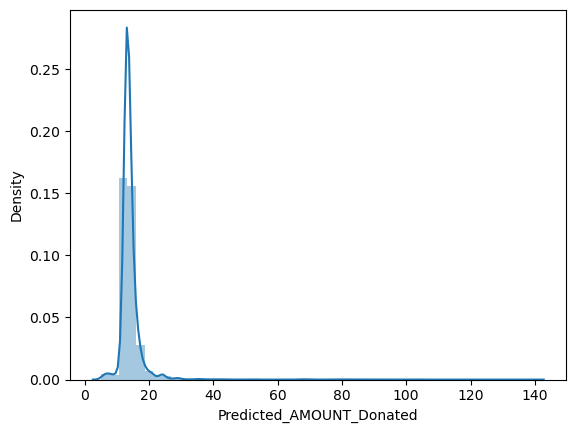

In [947]:
sns.distplot(test_df_reg["Predicted_AMOUNT_Donated"])

In [ ]:
Total_no_of_donars = 8441
Total_predicted_donations = 120706.3

In [955]:
14.302376 * 8441

120726.35581600001

# Optimized mail envelope strategy 

In [968]:

# Descriptive statistics of donation amounts
mean_donation = 14.302376
std_donation = 5.383672

# Cost of sending each type of envelope
cost_per_envelope_5 = 5
cost_per_envelope_1 = 1

# Total number of people
total_people = 8441

# Function to generate simulated donation amounts
def generate_simulated_donations(num_samples):
    return np.random.normal(mean_donation, std_donation, num_samples)

# Function to calculate net profit for a given number of people targeted with each envelope
def calculate_net_profit(num_people_5, num_people_1):
    donations_5 = generate_simulated_donations(num_people_5)
    donations_1 = generate_simulated_donations(num_people_1)
    
    total_donation_amount = np.sum(donations_5) + np.sum(donations_1)
    total_cost = (num_people_5 * cost_per_envelope_5) + (num_people_1 * cost_per_envelope_1)
    
    return total_donation_amount - total_cost

# Initialize with initial guesses for the number of people targeted with each envelope
optimal_num_people_5 = total_people // 2
optimal_num_people_1 = total_people // 2

# Iterate until convergence or maximum iterations
max_iterations = 1000
for _ in range(max_iterations):
    # Calculate net profit with current numbers
    current_net_profit = calculate_net_profit(optimal_num_people_5, optimal_num_people_1)
    
    # Adjust the number of people targeted with each envelope
    new_num_people_5 = optimal_num_people_5 + 1
    new_num_people_1 = optimal_num_people_1 - 1
    
    # Calculate net profit with the adjusted numbers
    new_net_profit = calculate_net_profit(new_num_people_5, new_num_people_1)
    
    # Update numbers if net profit improves
    if new_net_profit > current_net_profit:
        optimal_num_people_5 = new_num_people_5
        optimal_num_people_1 = new_num_people_1
    else:
        break  # Stop if net profit doesn't improve

# Print results
print("Optimal number of people to target with $5 envelope:", optimal_num_people_5)
print("Optimal number of people to target with $1 envelope:", optimal_num_people_1)
print("Maximum net profit:", current_net_profit)


Optimal number of people to target with $5 envelope: 4223
Optimal number of people to target with $1 envelope: 4217
Maximum net profit: 95805.42798671199
